# Deep Learning Image Classification

_Assignment for the University of Bath as part of MSc in Artificial Intelligence_

_Team Assignment with James Hancock_

This project compares various architectures in classifying handwritten digits using the MNIST dataset:

Section 1: Data Visualisation and Principal Component Analysis

Section 2: Binary Classification with Linear Perceptron

Section 3: Multi-Layer Perceptron

Section 4: Convolutional Neural Networks

Section 5: CNN Visualisations

Section 6: Multi-Task Learning


# Initial Setup

In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import keras
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from typing import Dict, Tuple, List, Union

sns.set_theme(style="whitegrid")

In [2]:
# Load the data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]
(n_train, n_test)

11501568/11490434 [==============================] - 0s 0us/step


(60000, 10000)

In [3]:
x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1

In [4]:
nb_features = np.prod(x_train.shape[1:])
x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


# Section 1: Data Visualisation and Principal Component Analysis

## Plot of PCA

In [5]:
# print the unique value in y_train
unique_values = np.unique(y_train)
print(unique_values)

[0 1 2 3 4 5 6 7 8 9]


In [6]:
from sklearn.decomposition import PCA

# implement PCA on the mnist data
pca = PCA()
pca.fit(x_train)
X_pca = pca.transform(x_train)

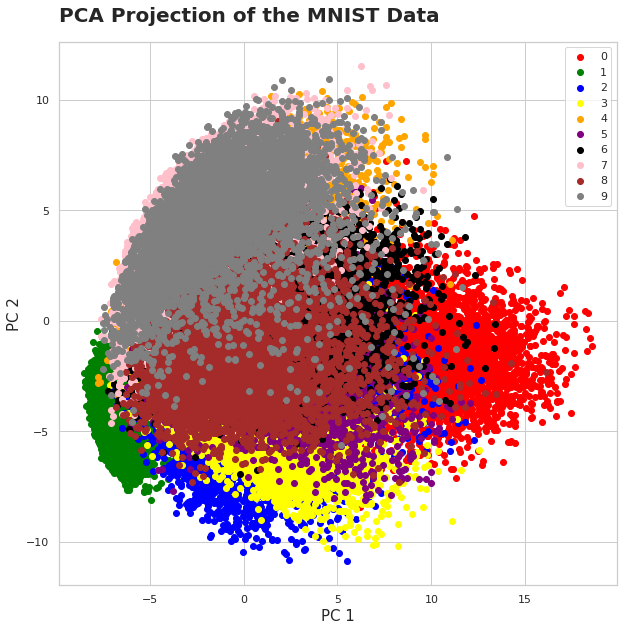

In [7]:
# create a list of 10 colors for the 10 classes
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'black', 'pink', 'brown', 'grey']

# plot the data points with different colors in 2D
fig, ax = plt.subplots(figsize=(10, 10))

for i in range(10):
    plt.scatter(X_pca[y_train == i, 0], X_pca[y_train == i, 1], c=colors[i], label=i)

plt.title('PCA Projection of the MNIST Data',
          fontdict={'fontsize': 20,
                    'fontweight': 'bold'},
          pad=20, loc='left')
plt.legend(loc='best')
plt.xlabel('PC 1', fontsize=15)
plt.ylabel('PC 2', fontsize=15)
plt.show()

In [8]:
# Proportion of variance in data explained by PC1 and PC2

PC1_explanation = pca.explained_variance_ratio_[0]
PC2_explanation = pca.explained_variance_ratio_[1]
PC1_explanation, PC2_explanation

(0.0970466435971392, 0.07095924059094486)

Each principal component (PC) explains a small amount of the dataset’s variance, with PC1 representing 9.7% and PC2 7.1%. However, these numbers are still high, given the 784 principal components. This 2D projection gives insight into how certain classes are distributed. For example, some handwritten digits have high variance, such as “9”, while others are far more clustered, such as “1”. This projection can also indicate which classes can be linearly separated, such as “9” and “3”.

## Classwise Linear Separation using Support Vector Machine

To assess which classes can be linearly separated, we utilise a Support Vector Machine (SVM) with a linear kernel for binary classification of each digit pair. This enables quantitative and qualitative linear separability assessments. The SVM is trained and evaluated on the same dataset, as we are simply assessing linear separability, not testing the SVM accuracy.

In [9]:
import itertools

class_combinations = list(itertools.combinations(unique_values, 2))

In [10]:
from sklearn.svm import SVC

SVMs = []
for i in tqdm(class_combinations[0:25]):
    X_SVM_1 = X_pca[y_train == i[0], 0:2]
    X_SVM_2 = X_pca[y_train == i[1], 0:2]
    X_SVM = np.vstack((X_SVM_1, X_SVM_2))
    y_SVM_1 = y_train[y_train == i[0]]
    y_SVM_2 = y_train[y_train == i[1]]
    y_SVM = np.concatenate((y_SVM_1, y_SVM_2))
    
    classifier = SVC(kernel='linear')
    classifier.fit(X_SVM, y_SVM)
    
    score =  np.round(classifier.score(X_SVM, y_SVM) * 100, 2)
    
    X1, X2 = np.meshgrid(np.arange(start = X_SVM[:, 0].min() - 1, stop = X_SVM[:, 0].max() + 1, step = 0.1),
                         np.arange(start = X_SVM[:, 1].min() - 1, stop = X_SVM[:, 1].max() + 1, step = 0.1))
    
    ravel_array = np.array([X1.ravel(), X2.ravel()]).T
    
    boundary_predictions = classifier.predict(ravel_array).reshape(X1.shape)
    
    
    SVMs.append([i, classifier, (X1, X2), boundary_predictions, score])

100%|██████████| 25/25 [02:21<00:00,  5.64s/it]


In [11]:
for i in tqdm(class_combinations[25:]):
    X_SVM_1 = X_pca[y_train == i[0], 0:2]
    X_SVM_2 = X_pca[y_train == i[1], 0:2]
    X_SVM = np.vstack((X_SVM_1, X_SVM_2))
    y_SVM_1 = y_train[y_train == i[0]]
    y_SVM_2 = y_train[y_train == i[1]]
    y_SVM = np.concatenate((y_SVM_1, y_SVM_2))
    
    classifier = SVC(kernel='linear')
    classifier.fit(X_SVM, y_SVM)
    
    score =  np.round(classifier.score(X_SVM, y_SVM) * 100, 2)
    
    X1, X2 = np.meshgrid(np.arange(start = X_SVM[:, 0].min() - 1, stop = X_SVM[:, 0].max() + 1, step = 0.1),
                         np.arange(start = X_SVM[:, 1].min() - 1, stop = X_SVM[:, 1].max() + 1, step = 0.1))
    
    ravel_array = np.array([X1.ravel(), X2.ravel()]).T
    
    boundary_predictions = classifier.predict(ravel_array).reshape(X1.shape)
    
    
    SVMs.append([i, classifier, (X1, X2), boundary_predictions, score])

100%|██████████| 20/20 [03:06<00:00,  9.34s/it]


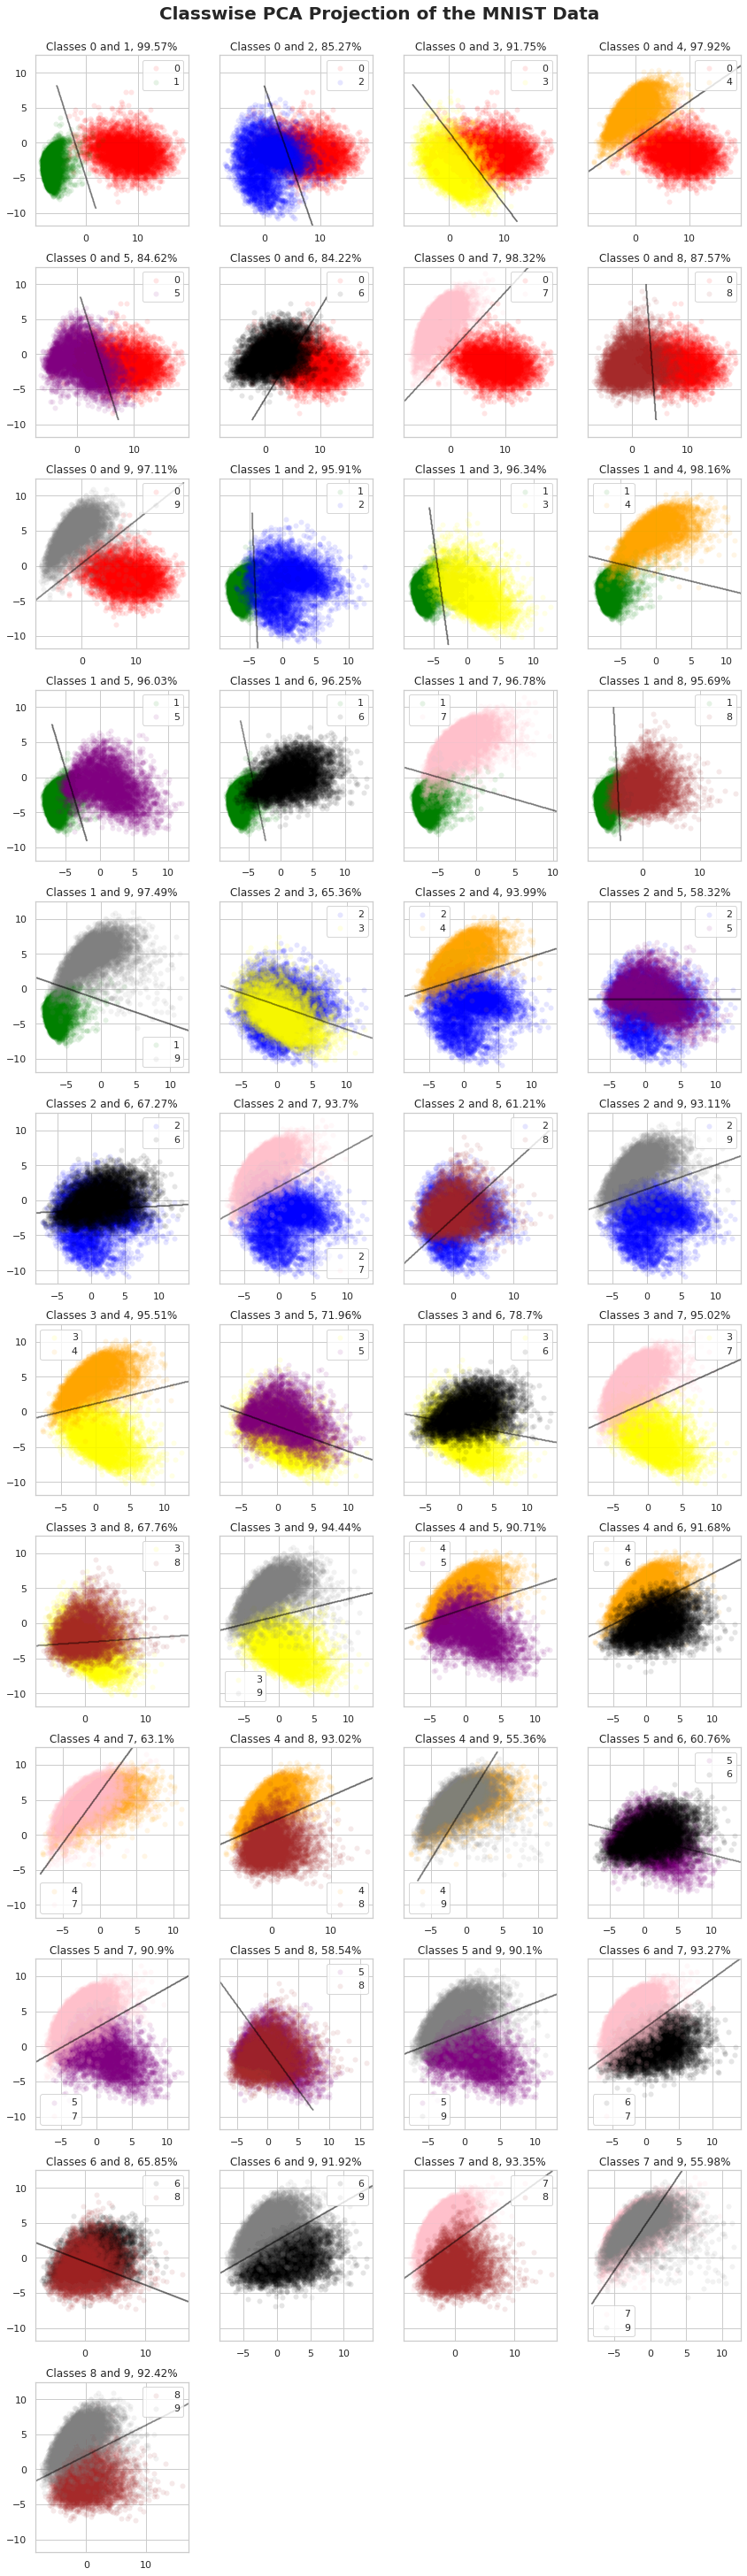

In [12]:
num_cols = 4
if len(class_combinations) % num_cols == 0:
    num_rows = len(class_combinations) // num_cols
else:
    num_rows = len(class_combinations) // num_cols + 1

num_remainder = len(class_combinations) % num_cols
alpha = 0.1
lw = 0

fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 40), sharey='all')

for i in range(len(class_combinations)):
    
    ax[i // num_cols, i % num_cols].contour(SVMs[i][2][0], SVMs[i][2][1], SVMs[i][3],
                 alpha=alpha, colors='black')
    
    ax[i // num_cols, i % num_cols].scatter(X_pca[y_train == class_combinations[i][0], 0],
                                            X_pca[y_train == class_combinations[i][0], 1],
                                            c=colors[class_combinations[i][0]], label=class_combinations[i][0],
                                            alpha=alpha, lw=lw)
    ax[i // num_cols, i % num_cols].scatter(X_pca[y_train == class_combinations[i][1], 0],
                                            X_pca[y_train == class_combinations[i][1], 1],
                                            c=colors[class_combinations[i][1]], label=class_combinations[i][1],
                                            alpha=alpha, lw=lw)
    ax[i // num_cols, i % num_cols].set_title(
        'Classes {} and {}, {}%'.format(class_combinations[i][0], class_combinations[i][1], SVMs[i][4]),
        fontdict={'fontsize': 12, }, )

    ax[i // num_cols, i % num_cols].legend(loc='best')

fig.suptitle('Classwise PCA Projection of the MNIST Data', y=1.01,
             fontsize=20, fontweight='bold', ha='center')

fig.tight_layout()
fig.delaxes(ax[-1, -1])
fig.delaxes(ax[-1, -2])
fig.delaxes(ax[-1, -3])

In [13]:
df = pd.DataFrame(data=[i[4] for i in SVMs], index=[i[0] for i in SVMs], columns=['SVM accuracy (%)'])
df.sort_values(by=['SVM accuracy (%)'], inplace=True, ascending=False)
df

,SVM accuracy (%)
"(0, 1)",99.57
"(0, 7)",98.32
"(1, 4)",98.16
"(0, 4)",97.92
"(1, 9)",97.49
"(0, 9)",97.11
"(1, 7)",96.78
"(1, 3)",96.34
"(1, 6)",96.25
"(1, 5)",96.03


In [14]:
df['SVM accuracy (%)'].mean()

84.94022222222223

The SVM accuracy shows ranging ability to linearly separate classes, supporting the qualitative evaluation. The most easily separated classes are 0 and 1, with 99.57% accuracy, while 4 and 9 are the lowest, with 55.36%. The average is 84.94%. This shows that the capacity to linearly separate classes ranges from almost perfect to almost pure chance. This is unsurprising since certain handwritten digits have similar shapes, whereas others differ greatly.

# Section 2: Binary Classification with Linear Perceptron


In [15]:
def binary_cat_gen(c1, c2, x1=x_train, y1=y_train, x2=x_test, y2=y_test):
    """
    Generates a list of tuples of the form (x, y, c) where c is the class of the tuple.

    Inputs:
    x1, y1, x2, y2: The x and y coordinates of the data points in the two classes.
    c1, c2: The class labels of the two classes.

    Returns:
    bx1, by1: The x and y coordinates of the training data
    bx2, by2: The x and y coordinates of the testing data
    """
    cond = (y1 == c1) + (y1 == c2)
    bx1 = x1[cond, :]
    by1 = y1[cond] * 1.0
    by1[by1 == c1] = -1
    by1[by1 == c2] = 1
    cond = (y2 == c1) + (y2 == c2)
    bx2 = x2[cond, :]
    by2 = y2[cond] * 1.0
    by2[by2 == c1] = -1
    by2[by2 == c2] = 1
    return bx1, by1, bx2, by2

In [16]:
# selecting classes 0 and 1

i_1 = 0
i_2 = 1

binary_x_train, binary_y_train, binary_x_test, binary_y_test = binary_cat_gen(i_1, i_2)

## 2.1 Perceptron Predict Function

In [17]:
def predict(x, w, b):
    """
    Implement a binary classifier with a single layer perceptron.

    Inputs:
    - x: a numpy array of shape (n, m) containing the input data, where n is the number of
      training examples and m is the number of features.
    - w: a numpy array of shape (m, 1) containing the weight vector.
    - b: a scalar corresponding to the bias.

    Returns:
    - pred: a numpy array of shape (n, 1) containing binary predictions: {-1, 1}
    """
    threshold = 0

    output = np.dot(x, w) + b
    pred = np.where(output > threshold, 1, -1)

    return pred

## 2.2 Optimise Perceptron

In [18]:
def optimise(x, y):
    """
    Optimize the parameters w and b of the perceptron.

    Inputs:
    - x: a numpy array of shape (n, m) containing the input data, where n is the number of
      training examples and m is the number of features.
    - y: a numpy array of shape (n, 1) containing the labels associated with each training
      example.

    Returns:
    - w: a numpy array of shape (m, 1) containing the learned weight vector.
    - b: a scalar corresponding to the learned bias.
    - error: a scalar corresponding to the classification error of the learned model on the training set.
    """

    niter = 0
    error = np.inf
    n, m = x.shape
    w_ = np.random.rand(m)
    b_ = np.random.rand()
    lr = 0.01
    
    error_list = []

    while (niter <= 1000) & (error > 0.001):
    
        i = np.random.choice(len(x))
        pred = predict(x[i], w_, b_)
        if pred != y[i]:
            w_ = w_ + lr * (y[i] - pred) * x[i]
            b_ = b_ + lr * (y[i] - pred)

        error = np.sum(np.abs(y - predict(x, w_, b_)) / 2) / len(y)
        error_list.append(error)
        niter += 1

    return w_, b_, error, error_list

In [19]:
weights, bias, e, el = optimise(binary_x_train, binary_y_train)

In [20]:
# predict test data classes

predictions = predict(binary_x_test, weights, bias)
accuracy = (1 - (np.count_nonzero(binary_y_test - predictions) / len(binary_y_test))) * 100
print(f"The final error for classes {i_1} and {i_2} is {e}, and the accuracy on the test data is {accuracy}%")

The final error for classes 0 and 1 is 0.009948677457560205, and the accuracy on the test data is 99.62174940898345%


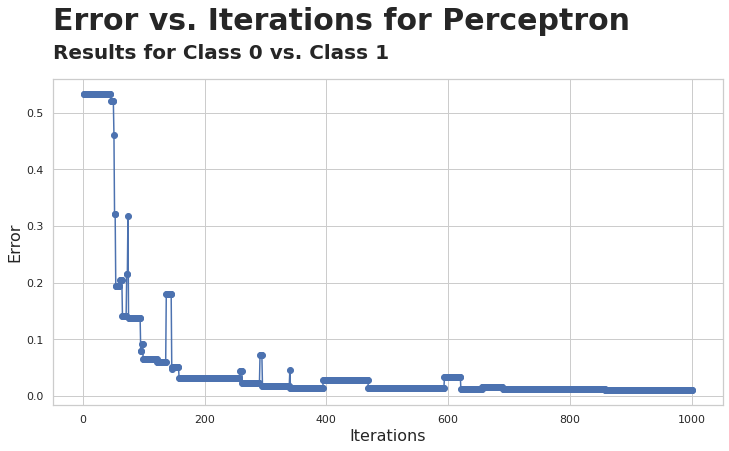

In [21]:
# plot training curve

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(el) + 1), el, marker='o')
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Error', fontsize=16)
fig.suptitle('Error vs. Iterations for Perceptron', fontsize=30, fontweight='bold',
             ha='left', va='bottom',
             x=0.125, y=0.98)
plt.title(f'Results for Class {i_1} vs. Class {i_2}',
          fontdict={
              'fontsize': 20,
              'fontweight': 'bold'
          },
          pad=20, loc='left')
plt.show()

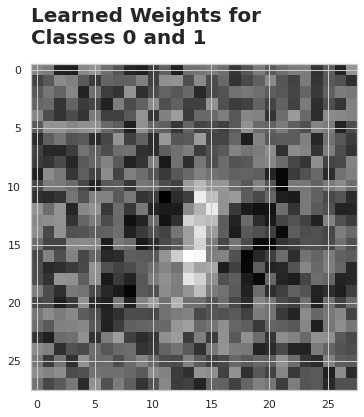

In [22]:
# plot learned weights

weights_matrix = np.reshape(weights, (28, 28))
_, ax = plt.subplots(figsize=(12, 6))
ax.imshow(weights_matrix, cmap='gray')
plt.title(f'Learned Weights for \nClasses {i_1} and {i_2}',
          fontsize=20, fontweight='bold',
          loc='left', pad=20)
plt.show()

The image above shows the learned weights after training. A lighter linear shape in the image’s middle, with surrounding dark areas, is seen. We thus see how the perceptron delineates class “1”, the white line in the middle of the image, from class “0”, the darker outside. The function appears to alter weights more heavily in areas of the image where the classes differ most.

In [23]:
# run the same experiment for 5 other class pairs

test_pairs = [(0, 7), (1, 4), (6, 9), (7, 9), (4, 9)]

weight_list = []
error_list = []
accuracy_list = []

for pair in test_pairs:
    i_1 = pair[0]
    i_2 = pair[1]

    temp_binary_x_train, temp_binary_y_train, temp_binary_x_test, temp_binary_y_test = binary_cat_gen(i_1, i_2)
    w, b, e, el = optimise(temp_binary_x_train, temp_binary_y_train)
    predictions = predict(temp_binary_x_test, w, b)
    accuracy = (1 - (np.count_nonzero(temp_binary_y_test - predictions) / len(temp_binary_y_test))) * 100
    
    weight_list.append(w)
    error_list.append(e)
    accuracy_list.append(accuracy)

df = pd.DataFrame(data=list(zip(error_list, accuracy_list)), index=test_pairs, columns=['Training error', 'Test accuracy (%)'])
df.sort_values(by=['Test accuracy (%)'], inplace=True, ascending=False)
df

,Training error,Test accuracy (%)
"(1, 4)",0.013350,98.819084
"(0, 7)",0.013374,98.804781
"(6, 9)",0.030505,96.695475
"(7, 9)",0.066317,94.256259
"(4, 9)",0.073870,92.867906


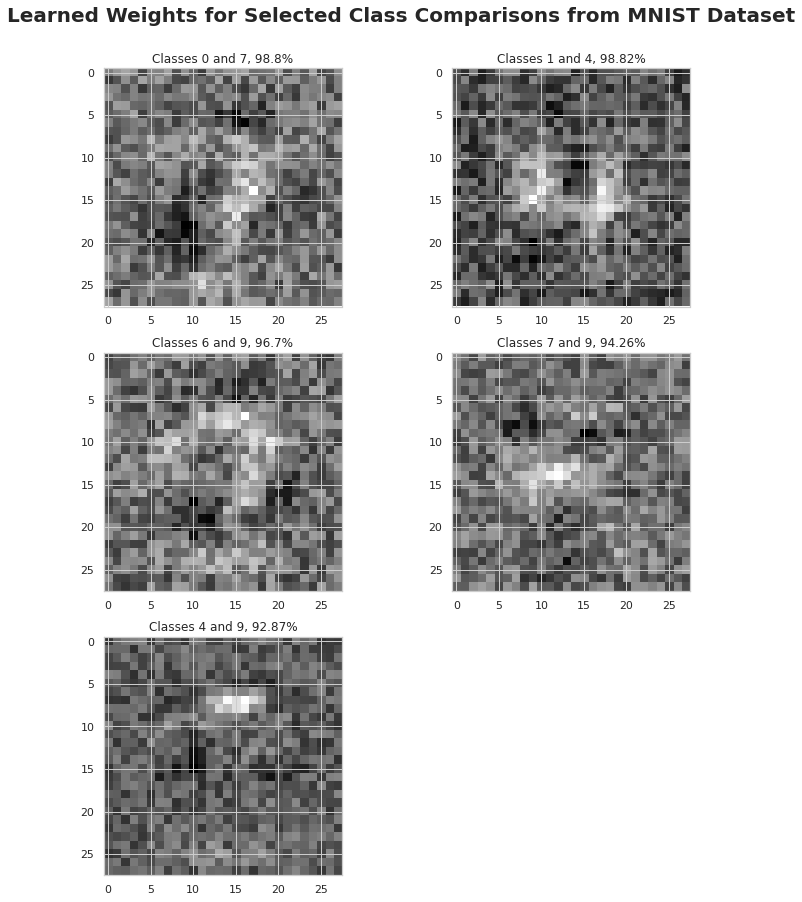

In [24]:
num_cols = 2

fig, ax = plt.subplots(nrows=3, ncols=num_cols, figsize=(10, 12))

for i, w in enumerate(weight_list):
    weights_matrix = np.reshape(w, (28, 28))

    ax[i // num_cols, i % num_cols].imshow(weights_matrix, cmap='gray')
    ax[i // num_cols, i % num_cols].set_title(
        'Classes {} and {}, {}%'.format(test_pairs[i][0], test_pairs[i][1], round(accuracy_list[i], 2)),
        fontdict={'fontsize': 12, }, )


fig.suptitle('Learned Weights for Selected Class Comparisons from MNIST Dataset', y=1.04,
             fontsize=20, fontweight='bold', ha='center')

fig.tight_layout()
fig.delaxes(ax[-1, -1])
    
plt.show()

The above image illustrates how, as the pairs’ linear separability decreases, so does the clarity of the image of one of the classes within the weights. For example, the numbers 7 and 4 appear  within the first two images, while 9 is apparent in neither of the last two. As with 1 and 0, the perceptron highlights areas where the two classes differ most, and is less able to do this effectively when the classes are aesthetically similar.

# Section 3: Multi-Layer Perceptron

In [25]:
# Load the data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1
n_train = x_train.shape[0]
n_test = x_test.shape[0]
(n_train, n_test)

(60000, 10000)

In [26]:
y_test = np.eye(10)[y_test]
y_train = np.eye(10)[y_train]

## Create an MLP


In [27]:
n_classes = 10
input_shape = (28, 28)

In [28]:
# Model Architecture

n_hidden_layers = 2

model_name = f"Task_3.1_MLP_Hidden-0{n_hidden_layers}"

epochs = 10
batch_size = 120
learning_rate = 0.001
hidden_units = [1000, 1000]
hidden_activation = 'relu'
output_layer_units = 10
output_layer_activation = 'softmax'
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model_mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(hidden_units[0], activation=hidden_activation),
    tf.keras.layers.Dense(hidden_units[1], activation=hidden_activation),
    tf.keras.layers.Dense(output_layer_units, activation=output_layer_activation)
])

model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1000)              785000    
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 10)                10010     
                                                                 
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________


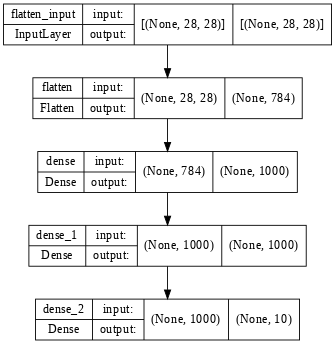

In [29]:
tf.keras.utils.plot_model(model_mlp, show_shapes=True, expand_nested=True, dpi=64)

In [30]:
model_mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics,
)

model_mlp_history = model_mlp.fit(x_train, y_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  validation_data=(x_test, y_test),
                                  verbose=2,
                                  shuffle=True
                                  )

Epoch 1/10
500/500 - 4s - loss: 0.2701 - accuracy: 0.9189 - val_loss: 0.1498 - val_accuracy: 0.9507 - 4s/epoch - 8ms/step
Epoch 2/10
500/500 - 1s - loss: 0.1197 - accuracy: 0.9619 - val_loss: 0.1333 - val_accuracy: 0.9550 - 1s/epoch - 3ms/step
Epoch 3/10
500/500 - 1s - loss: 0.0880 - accuracy: 0.9721 - val_loss: 0.1028 - val_accuracy: 0.9669 - 1s/epoch - 3ms/step
Epoch 4/10
500/500 - 1s - loss: 0.0728 - accuracy: 0.9765 - val_loss: 0.0848 - val_accuracy: 0.9748 - 1s/epoch - 2ms/step
Epoch 5/10
500/500 - 1s - loss: 0.0603 - accuracy: 0.9804 - val_loss: 0.0895 - val_accuracy: 0.9720 - 1s/epoch - 2ms/step
Epoch 6/10
500/500 - 1s - loss: 0.0558 - accuracy: 0.9820 - val_loss: 0.1063 - val_accuracy: 0.9726 - 1s/epoch - 3ms/step
Epoch 7/10
500/500 - 1s - loss: 0.0457 - accuracy: 0.9850 - val_loss: 0.0962 - val_accuracy: 0.9724 - 1s/epoch - 3ms/step
Epoch 8/10
500/500 - 1s - loss: 0.0446 - accuracy: 0.9851 - val_loss: 0.0898 - val_accuracy: 0.9734 - 1s/epoch - 3ms/step
Epoch 9/10
500/500 - 1s 

In [31]:
# model accuracy

summary_list = []
train_acc, test_acc = model_mlp.evaluate(x_train, y_train), model_mlp.evaluate(x_test, y_test)
summary_list.append((model_name, train_acc[1], test_acc[1]))

313/313 [==============================] - 1s 2ms/step - loss: 0.0762 - accuracy: 0.9792


## MLP Network Comparisons


In [32]:
history_list = []

In [33]:
# Model 1

n_hidden_layers = 3
model_id = 1

model_name = f"Task_3.2_MLP_Hidden-0{n_hidden_layers}"

epochs = 10
batch_size = 120
learning_rate = 0.001
hidden_units = [1000, 1000, 1000]
hidden_activation = 'relu'
output_layer_units = 10
output_layer_activation = 'softmax'
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(hidden_units[0], activation=hidden_activation),
    tf.keras.layers.Dense(hidden_units[1], activation=hidden_activation),
    tf.keras.layers.Dense(hidden_units[2], activation=hidden_activation),
    tf.keras.layers.Dense(output_layer_units, activation=output_layer_activation)
])


model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 1000)              785000    
                                                                 
 dense_4 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_5 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_6 (Dense)             (None, 10)                10010     
                                                                 
Total params: 2,797,010
Trainable params: 2,797,010
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics,
)

history_list.append(model_1.fit(x_train, y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                validation_data=(x_test, y_test),
                                verbose=2,
                                shuffle=True))

Epoch 1/10
500/500 - 2s - loss: 0.2722 - accuracy: 0.9157 - val_loss: 0.1259 - val_accuracy: 0.9613 - 2s/epoch - 4ms/step
Epoch 2/10
500/500 - 1s - loss: 0.1261 - accuracy: 0.9615 - val_loss: 0.1118 - val_accuracy: 0.9634 - 1s/epoch - 2ms/step
Epoch 3/10
500/500 - 1s - loss: 0.0988 - accuracy: 0.9691 - val_loss: 0.1008 - val_accuracy: 0.9689 - 1s/epoch - 2ms/step
Epoch 4/10
500/500 - 1s - loss: 0.0812 - accuracy: 0.9734 - val_loss: 0.1008 - val_accuracy: 0.9712 - 1s/epoch - 2ms/step
Epoch 5/10
500/500 - 1s - loss: 0.0686 - accuracy: 0.9776 - val_loss: 0.0959 - val_accuracy: 0.9704 - 1s/epoch - 3ms/step
Epoch 6/10
500/500 - 1s - loss: 0.0635 - accuracy: 0.9796 - val_loss: 0.1107 - val_accuracy: 0.9707 - 1s/epoch - 2ms/step
Epoch 7/10
500/500 - 1s - loss: 0.0541 - accuracy: 0.9826 - val_loss: 0.1016 - val_accuracy: 0.9732 - 1s/epoch - 2ms/step
Epoch 8/10
500/500 - 1s - loss: 0.0476 - accuracy: 0.9850 - val_loss: 0.0787 - val_accuracy: 0.9792 - 1s/epoch - 3ms/step
Epoch 9/10
500/500 - 1s 

In [35]:
train_acc, test_acc = model_1.evaluate(x_train, y_train), model_1.evaluate(x_test, y_test)
summary_list.append((model_name, train_acc[1], test_acc[1]))

313/313 [==============================] - 1s 2ms/step - loss: 0.0906 - accuracy: 0.9720


In [36]:
# Model 2

n_hidden_layers = 4
model_id = 2

model_name = f"Task_3.2_MLP_Hidden-0{n_hidden_layers}"

epochs = 10
batch_size = 120
learning_rate = 0.001
input_shape = (28, 28)
hidden_units = [1000, 1000, 1000, 1000]
hidden_activation = 'relu'
output_layer_units = 10
output_layer_activation = 'softmax'
n_layers = len(hidden_units) + 1
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(hidden_units[0], activation=hidden_activation),
    tf.keras.layers.Dense(hidden_units[1], activation=hidden_activation),
    tf.keras.layers.Dense(hidden_units[2], activation=hidden_activation),
    tf.keras.layers.Dense(hidden_units[3], activation=hidden_activation),
    tf.keras.layers.Dense(output_layer_units, activation=output_layer_activation)
])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 1000)              785000    
                                                                 
 dense_8 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_9 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_10 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_11 (Dense)            (None, 10)                10010     
                                                                 
Total params: 3,798,010
Trainable params: 3,798,010
No

In [38]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics,
)

history_list.append(model_2.fit(x_train, y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                validation_data=(x_test, y_test),
                                verbose=2,
                                shuffle=True,
                                ))

Epoch 1/10
500/500 - 4s - loss: 0.2872 - accuracy: 0.9105 - val_loss: 0.1369 - val_accuracy: 0.9568 - 4s/epoch - 7ms/step
Epoch 2/10
500/500 - 2s - loss: 0.1392 - accuracy: 0.9577 - val_loss: 0.1284 - val_accuracy: 0.9602 - 2s/epoch - 5ms/step
Epoch 3/10
500/500 - 3s - loss: 0.1059 - accuracy: 0.9675 - val_loss: 0.1129 - val_accuracy: 0.9651 - 3s/epoch - 5ms/step
Epoch 4/10
500/500 - 2s - loss: 0.0892 - accuracy: 0.9735 - val_loss: 0.0989 - val_accuracy: 0.9688 - 2s/epoch - 5ms/step
Epoch 5/10
500/500 - 2s - loss: 0.0768 - accuracy: 0.9761 - val_loss: 0.0954 - val_accuracy: 0.9726 - 2s/epoch - 5ms/step
Epoch 6/10
500/500 - 2s - loss: 0.0654 - accuracy: 0.9798 - val_loss: 0.1018 - val_accuracy: 0.9731 - 2s/epoch - 5ms/step
Epoch 7/10
500/500 - 2s - loss: 0.0626 - accuracy: 0.9807 - val_loss: 0.1025 - val_accuracy: 0.9738 - 2s/epoch - 4ms/step
Epoch 8/10
500/500 - 1s - loss: 0.0568 - accuracy: 0.9820 - val_loss: 0.1050 - val_accuracy: 0.9696 - 1s/epoch - 3ms/step
Epoch 9/10
500/500 - 1s 

In [39]:
train_acc, test_acc = model_2.evaluate(x_train, y_train), model_2.evaluate(x_test, y_test)
summary_list.append((model_name, train_acc[1], test_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.0978 - accuracy: 0.9731


In [40]:
# Model 3

n_hidden_layers = 7
model_id = 3

model_name = f"Task_3.2_MLP_Hidden-0{n_hidden_layers}"

epochs = 10
batch_size = 120
learning_rate = 0.001
input_shape = (28, 28)
hidden_units = [1000, 1000, 1000, 1000, 1000, 1000, 1000]
hidden_activation = 'relu'
output_layer_units = 10
output_layer_activation = 'softmax'
n_layers = len(hidden_units) + 1
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(hidden_units[0], activation=hidden_activation),
    tf.keras.layers.Dense(hidden_units[1], activation=hidden_activation),
    tf.keras.layers.Dense(hidden_units[2], activation=hidden_activation),
    tf.keras.layers.Dense(hidden_units[3], activation=hidden_activation),
    tf.keras.layers.Dense(hidden_units[4], activation=hidden_activation),
    tf.keras.layers.Dense(hidden_units[5], activation=hidden_activation),
    tf.keras.layers.Dense(hidden_units[6], activation=hidden_activation),
    tf.keras.layers.Dense(output_layer_units, activation=output_layer_activation)
])


model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 1000)              785000    
                                                                 
 dense_13 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_14 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_15 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_16 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_17 (Dense)            (None, 1000)             

In [41]:
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics,
)

history_list.append(model_3.fit(x_train, y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                validation_data=(x_test, y_test),
                                verbose=2,
                                shuffle=True
                                ))

Epoch 1/10
500/500 - 3s - loss: 0.3707 - accuracy: 0.8871 - val_loss: 0.1797 - val_accuracy: 0.9524 - 3s/epoch - 5ms/step
Epoch 2/10
500/500 - 2s - loss: 0.1786 - accuracy: 0.9503 - val_loss: 0.1624 - val_accuracy: 0.9538 - 2s/epoch - 4ms/step
Epoch 3/10
500/500 - 2s - loss: 0.1381 - accuracy: 0.9616 - val_loss: 0.2077 - val_accuracy: 0.9488 - 2s/epoch - 4ms/step
Epoch 4/10
500/500 - 2s - loss: 0.1159 - accuracy: 0.9682 - val_loss: 0.1381 - val_accuracy: 0.9637 - 2s/epoch - 4ms/step
Epoch 5/10
500/500 - 2s - loss: 0.1045 - accuracy: 0.9704 - val_loss: 0.1254 - val_accuracy: 0.9665 - 2s/epoch - 4ms/step
Epoch 6/10
500/500 - 2s - loss: 0.0920 - accuracy: 0.9754 - val_loss: 0.1268 - val_accuracy: 0.9688 - 2s/epoch - 4ms/step
Epoch 7/10
500/500 - 2s - loss: 0.0854 - accuracy: 0.9774 - val_loss: 0.1329 - val_accuracy: 0.9659 - 2s/epoch - 4ms/step
Epoch 8/10
500/500 - 2s - loss: 0.0750 - accuracy: 0.9796 - val_loss: 0.0991 - val_accuracy: 0.9749 - 2s/epoch - 4ms/step
Epoch 9/10
500/500 - 2s 

In [42]:
train_acc, test_acc = model_3.evaluate(x_train, y_train), model_3.evaluate(x_test, y_test)
summary_list.append((model_name, train_acc[1], test_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.1184 - accuracy: 0.9720


In [43]:
# Model 4

n_hidden_layers = 4
n_dropout_layers = 2
model_id = 5

model_name = f"Task_3.2_MLP_Hidden-0{n_hidden_layers}_inc_0{n_dropout_layers}_Dropout"

epochs = 10
batch_size = 120
learning_rate = 0.001
input_shape = (28, 28)
hidden_units = [1000, 1000]
hidden_activation = 'relu'
dropout_layers = [0.2, 0.2]
output_layer_units = 10
output_layer_activation = 'softmax'
n_layers = len(hidden_units) + 1
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model_4 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(hidden_units[0], activation=hidden_activation),
    tf.keras.layers.Dropout(dropout_layers[0]),
    tf.keras.layers.Dense(hidden_units[1], activation=hidden_activation),
    tf.keras.layers.Dropout(dropout_layers[1]),
    tf.keras.layers.Dense(output_layer_units, activation=output_layer_activation)
])


model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_20 (Dense)            (None, 1000)              785000    
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_21 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_22 (Dense)            (None, 10)                10010     
                                                                 
Total params: 1,796,010
Trainable params: 1,796,010
No

In [44]:
model_4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss,
    metrics=metrics,
)

history_list.append(model_4.fit(x_train, y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                validation_data=(x_test, y_test),
                                verbose=2,
                                shuffle=True
                                ))

Epoch 1/10
500/500 - 2s - loss: 0.3187 - accuracy: 0.9021 - val_loss: 0.1395 - val_accuracy: 0.9579 - 2s/epoch - 4ms/step
Epoch 2/10
500/500 - 1s - loss: 0.1622 - accuracy: 0.9503 - val_loss: 0.1167 - val_accuracy: 0.9634 - 1s/epoch - 2ms/step
Epoch 3/10
500/500 - 1s - loss: 0.1291 - accuracy: 0.9598 - val_loss: 0.1056 - val_accuracy: 0.9671 - 1s/epoch - 3ms/step
Epoch 4/10
500/500 - 1s - loss: 0.1120 - accuracy: 0.9652 - val_loss: 0.0998 - val_accuracy: 0.9684 - 1s/epoch - 2ms/step
Epoch 5/10
500/500 - 1s - loss: 0.1020 - accuracy: 0.9670 - val_loss: 0.0847 - val_accuracy: 0.9732 - 1s/epoch - 2ms/step
Epoch 6/10
500/500 - 1s - loss: 0.0893 - accuracy: 0.9719 - val_loss: 0.0860 - val_accuracy: 0.9748 - 1s/epoch - 2ms/step
Epoch 7/10
500/500 - 1s - loss: 0.0845 - accuracy: 0.9735 - val_loss: 0.0756 - val_accuracy: 0.9765 - 1s/epoch - 2ms/step
Epoch 8/10
500/500 - 1s - loss: 0.0754 - accuracy: 0.9761 - val_loss: 0.0719 - val_accuracy: 0.9771 - 1s/epoch - 2ms/step
Epoch 9/10
500/500 - 1s 

In [45]:
train_acc, test_acc = model_4.evaluate(x_train, y_train), model_4.evaluate(x_test, y_test)
summary_list.append((model_name, train_acc[1], test_acc[1]))

313/313 [==============================] - 1s 2ms/step - loss: 0.0727 - accuracy: 0.9795


In [46]:
df = pd.DataFrame(summary_list, columns=['Model', 'Training data accuracy', 'Test data accuracy'])
df.sort_values(by=['Test data accuracy'], inplace=True, ascending=False)
df

,Model,Training data accuracy,Test data accuracy
4,Task_3.2_MLP_Hidden-04_inc_02_Dropout,0.988267,0.9795
0,Task_3.1_MLP_Hidden-02,0.993783,0.9792
2,Task_3.2_MLP_Hidden-04,0.986633,0.9731
1,Task_3.2_MLP_Hidden-03,0.986983,0.9720
3,Task_3.2_MLP_Hidden-07,0.982900,0.9720


5 different networks were chosen for comparison. First, four traditional networks were chosen, with 2, 3, 4, and 7 layers. The width of these networks remained unaltered to understand the relationship between network depth and classification accuracy. An additional network was chosen with four layers but constructed of two dense layers and two dropout layers. The rationale for this latter design was to reduce the overfitting observed in MLPs (Srivastava et al., 2014). As shown in the table above, adding hidden layers does not improve the classification accuracy of the MLP greatly. 

# Section 4: Convolutional Neural Networks

In [47]:
import numpy as np
from tensorflow import keras
from keras import layers

In [48]:
n_classes = 10
input_shape = (28, 28, 1)

In [49]:
# Reloading the dataset

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [50]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

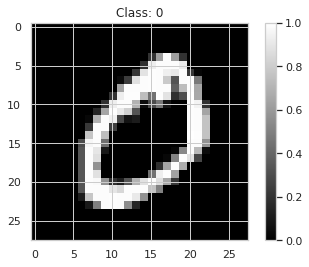

In [51]:
fig, ax = plt.subplots()
ax.imshow(x_train[1], cmap='gray')
ax.set_title('Class: ' + str(y_train[1]))
fig.colorbar(ax.images[0], ax=ax)
plt.show()

In [52]:
# Make sure images have shape (None, 28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print("training samples:", x_train.shape[0])
print("testing samples:", x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
training samples: 60000
testing samples: 10000


In [53]:
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

## Create a CNN

In [54]:
model_id = 1
model_name = "Task_4.1_CNN"

epochs = 10
batch_size = 120
learning_rate = 0.001
conv_layers = [32, 64, 128]
kernel_size = [(4, 4), (4, 4), (4, 4)]
strides = [(1, 1), (2, 2), (2, 2)]
dropout_layers = None
hidden_activation = 'relu'
output_layer_activation = 'softmax'
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

# Create the model
model_cnn_01 = keras.Sequential([
    keras.Input(shape=input_shape),
    Conv2D(conv_layers[0], kernel_size=kernel_size[0], strides=strides[0], activation=hidden_activation),
    Conv2D(conv_layers[1], kernel_size=kernel_size[1], strides=strides[1], activation=hidden_activation),
    Conv2D(conv_layers[2], kernel_size=kernel_size[2], strides=strides[2], activation=hidden_activation),
    Flatten(),
    Dense(n_classes, activation=output_layer_activation)
])


model_cnn_01.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        544       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         131200    
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_23 (Dense)            (None, 10)                20490     
                                                                 
Total params: 185,066
Trainable params: 185,066
Non-trainable params: 0
_________________________________________________________________


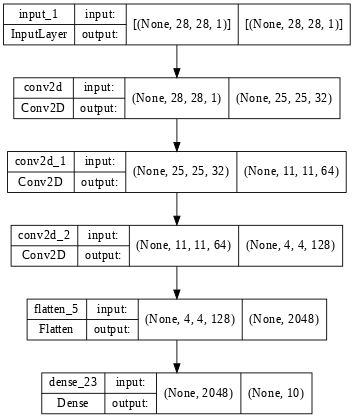

In [55]:
tf.keras.utils.plot_model(model_cnn_01, show_shapes=True, expand_nested=True, dpi=64)

In [56]:
model_cnn_01.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

model_cnn_01.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test)
)


Epoch 1/10
500/500 [==============================] - 12s 7ms/step - loss: 0.2028 - accuracy: 0.9405 - val_loss: 0.0582 - val_accuracy: 0.9820
Epoch 2/10
500/500 [==============================] - 4s 7ms/step - loss: 0.0575 - accuracy: 0.9826 - val_loss: 0.0446 - val_accuracy: 0.9844
Epoch 3/10
500/500 [==============================] - 5s 9ms/step - loss: 0.0381 - accuracy: 0.9880 - val_loss: 0.0359 - val_accuracy: 0.9888
Epoch 4/10
500/500 [==============================] - 4s 8ms/step - loss: 0.0287 - accuracy: 0.9908 - val_loss: 0.0345 - val_accuracy: 0.9893
Epoch 5/10
500/500 [==============================] - 4s 8ms/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 0.0354 - val_accuracy: 0.9897
Epoch 6/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0176 - accuracy: 0.9945 - val_loss: 0.0288 - val_accuracy: 0.9907
Epoch 7/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.0352 - val_accuracy: 0.9901
Epoch

In [57]:
summary_list_cnn = []
train_acc, test_acc = model_cnn_01.evaluate(x_train, y_train), model_cnn_01.evaluate(x_test, y_test)
summary_list_cnn.append((model_name, train_acc[1], test_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.0329 - accuracy: 0.9914


## 4.2 CNN Comparisons

In [58]:
model_id = 2
model_name = "Task_4.2_CNN_+conv"

epochs = 10
batch_size = 120
learning_rate = 0.001
conv_layers = [32, 64, 128, 256]
kernel_size = [(4, 4), (4, 4), (4, 4), (4, 4)]
strides = [(1, 1), (2, 2), (2, 2), (2, 2)]
dropout_layers = None
hidden_activation = 'relu'
output_layer_activation = 'softmax'
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

# Create the model
model_cnn_02 = keras.Sequential([
    keras.Input(shape=input_shape),
    Conv2D(conv_layers[0], kernel_size=kernel_size[0], strides=strides[0], activation=hidden_activation),
    Conv2D(conv_layers[1], kernel_size=kernel_size[1], strides=strides[1], activation=hidden_activation),
    Conv2D(conv_layers[2], kernel_size=kernel_size[2], strides=strides[2], activation=hidden_activation),
    Conv2D(conv_layers[3], kernel_size=kernel_size[3], strides=strides[3], activation=hidden_activation),
    Flatten(),
    Dense(n_classes, activation=output_layer_activation)
])

model_cnn_02.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 25, 25, 32)        544       
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        32832     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         131200    
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 1, 256)         524544    
                                                                 
 flatten_6 (Flatten)         (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 10)                2570      
                                                                 
Total params: 691,690
Trainable params: 691,690
Non-tr

In [59]:
model_cnn_02.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

model_cnn_02.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
)


Epoch 1/10
500/500 [==============================] - 5s 7ms/step - loss: 0.1660 - accuracy: 0.9492 - val_loss: 0.0546 - val_accuracy: 0.9824
Epoch 2/10
500/500 [==============================] - 4s 7ms/step - loss: 0.0467 - accuracy: 0.9851 - val_loss: 0.0348 - val_accuracy: 0.9891
Epoch 3/10
500/500 [==============================] - 4s 7ms/step - loss: 0.0288 - accuracy: 0.9910 - val_loss: 0.0355 - val_accuracy: 0.9888
Epoch 4/10
500/500 [==============================] - 4s 7ms/step - loss: 0.0215 - accuracy: 0.9930 - val_loss: 0.0338 - val_accuracy: 0.9908
Epoch 5/10
500/500 [==============================] - 3s 7ms/step - loss: 0.0171 - accuracy: 0.9948 - val_loss: 0.0413 - val_accuracy: 0.9881
Epoch 6/10
500/500 [==============================] - 4s 7ms/step - loss: 0.0146 - accuracy: 0.9954 - val_loss: 0.0374 - val_accuracy: 0.9894
Epoch 7/10
500/500 [==============================] - 3s 7ms/step - loss: 0.0111 - accuracy: 0.9965 - val_loss: 0.0396 - val_accuracy: 0.9892
Epoch 

In [60]:
train_acc, test_acc = model_cnn_02.evaluate(x_train, y_train), model_cnn_02.evaluate(x_test, y_test)
summary_list_cnn.append((model_name, train_acc[1], test_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.0351 - accuracy: 0.9908


In [61]:
model_id = 3
model_name = "Task_4.2_CNN_+dense"

epochs = 10
batch_size = 120
learning_rate = 0.001
conv_layers = [32, 64, 128]
kernel_size = [(4, 4), (4, 4), (4, 4)]
strides = [(1, 1), (2, 2), (2, 2)]
dense_layers = [1000]
dropout_layers = None
hidden_activation = 'relu'
output_layer_activation = 'softmax'
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

# Create the model
model_cnn_03 = keras.Sequential([
    keras.Input(shape=input_shape),
    Conv2D(conv_layers[0], kernel_size=kernel_size[0], strides=strides[0], activation=hidden_activation),
    Conv2D(conv_layers[1], kernel_size=kernel_size[1], strides=strides[1], activation=hidden_activation),
    Conv2D(conv_layers[2], kernel_size=kernel_size[2], strides=strides[2], activation=hidden_activation),
    Flatten(),
    Dense(dense_layers[0], activation=hidden_activation),
    Dense(n_classes, activation=output_layer_activation),
])


model_cnn_03.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 25, 25, 32)        544       
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 64)        32832     
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 128)         131200    
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_25 (Dense)            (None, 1000)              2049000   
                                                                 
 dense_26 (Dense)            (None, 10)                10010     
                                                                 
Total params: 2,223,586
Trainable params: 2,223,586
No

In [62]:
model_cnn_03.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

model_cnn_03.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
)


Epoch 1/10
500/500 [==============================] - 4s 7ms/step - loss: 0.1479 - accuracy: 0.9556 - val_loss: 0.0395 - val_accuracy: 0.9875
Epoch 2/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0410 - accuracy: 0.9872 - val_loss: 0.0297 - val_accuracy: 0.9904
Epoch 3/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0263 - accuracy: 0.9918 - val_loss: 0.0309 - val_accuracy: 0.9911
Epoch 4/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0202 - accuracy: 0.9932 - val_loss: 0.0330 - val_accuracy: 0.9911
Epoch 5/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0149 - accuracy: 0.9955 - val_loss: 0.0347 - val_accuracy: 0.9905
Epoch 6/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0341 - val_accuracy: 0.9898
Epoch 7/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0097 - accuracy: 0.9970 - val_loss: 0.0368 - val_accuracy: 0.9908
Epoch 

In [63]:
train_acc, test_acc = model_cnn_03.evaluate(x_train, y_train), model_cnn_03.evaluate(x_test, y_test)
summary_list_cnn.append((model_name, train_acc[1], test_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.0423 - accuracy: 0.9880


In [64]:
model_id = 4
model_name = "Task_4.2_CNN_+dropout"

epochs = 10
batch_size = 120
learning_rate = 0.001
conv_layers = [32, 64, 128]
kernel_size = [(4, 4), (4, 4), (4, 4)]
strides = [(1, 1), (2, 2), (2, 2)]
dropout_layers = [0.2]
hidden_activation = 'relu'
output_layer_activation = 'softmax'
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

# Create the model
model_cnn_04 = keras.Sequential([
    keras.Input(shape=input_shape),
    Conv2D(conv_layers[0], kernel_size=kernel_size[0], strides=strides[0], activation=hidden_activation),
    Conv2D(conv_layers[1], kernel_size=kernel_size[1], strides=strides[1], activation=hidden_activation),
    Conv2D(conv_layers[2], kernel_size=kernel_size[2], strides=strides[2], activation=hidden_activation),
    Flatten(),
    Dropout(dropout_layers[0]),
    Dense(n_classes, activation=output_layer_activation)
])


model_cnn_04.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 25, 25, 32)        544       
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 64)        32832     
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 128)         131200    
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_27 (Dense)            (None, 10)                20490     
                                                                 
Total params: 185,066
Trainable params: 185,066
Non-tr

In [65]:
model_cnn_04.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

model_cnn_04.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
)


Epoch 1/10
500/500 [==============================] - 4s 6ms/step - loss: 0.2171 - accuracy: 0.9357 - val_loss: 0.0579 - val_accuracy: 0.9818
Epoch 2/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0626 - accuracy: 0.9809 - val_loss: 0.0487 - val_accuracy: 0.9834
Epoch 3/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0439 - accuracy: 0.9866 - val_loss: 0.0324 - val_accuracy: 0.9895
Epoch 4/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0333 - accuracy: 0.9898 - val_loss: 0.0377 - val_accuracy: 0.9884
Epoch 5/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0281 - accuracy: 0.9909 - val_loss: 0.0320 - val_accuracy: 0.9907
Epoch 6/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0229 - accuracy: 0.9925 - val_loss: 0.0302 - val_accuracy: 0.9901
Epoch 7/10
500/500 [==============================] - 3s 6ms/step - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.0307 - val_accuracy: 0.9901
Epoch 

In [66]:
train_acc, test_acc = model_cnn_04.evaluate(x_train, y_train), model_cnn_04.evaluate(x_test, y_test)
summary_list_cnn.append((model_name, train_acc[1], test_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.0293 - accuracy: 0.9918


The following model is an implementation of the VGG16 model, first implemented in:

https://arxiv.org/abs/1409.1556

In [67]:
model_id = 5
model_name = "Task_4.2_CNN_VGG16"

chanDim = -1

conv_layers = [32, 32, 64, 64]
kernel_size = [(3, 3), (3, 3), (3, 3), (3, 3)]
strides = [(1, 1), (2, 2), (2, 2)]
dropout_layers = [0.25, 0.25, 0.5]
hidden_units = [512]
hidden_activation = 'relu'
output_layer_activation = 'softmax'
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']
padding = 'same'
pool_size = [(2, 2), (2, 2)]

model_cnn_05 = keras.Sequential([
    # first CONV => RELU => CONV => RELU => POOL layer set
    keras.Input(shape=input_shape),
    Conv2D(conv_layers[0], kernel_size=kernel_size[0], padding=padding, activation=hidden_activation),
    BatchNormalization(axis=chanDim),
    Conv2D(conv_layers[1], kernel_size=kernel_size[1], padding=padding, activation=hidden_activation),
    BatchNormalization(axis=chanDim),
    MaxPooling2D(pool_size=pool_size[0]),
    Dropout(dropout_layers[0]),
    # second CONV => RELU => CONV => RELU => POOL layer set
    Conv2D(conv_layers[2], kernel_size=kernel_size[2], padding=padding, activation=hidden_activation),
    BatchNormalization(axis=chanDim),
    Conv2D(conv_layers[3], kernel_size=kernel_size[3], padding=padding, activation=hidden_activation),
    BatchNormalization(axis=chanDim),
    MaxPooling2D(pool_size=pool_size[1]),
    Dropout(dropout_layers[1]),
    # Dense => RELU layer
    Flatten(),
    Dense(hidden_units[0], activation=hidden_activation),
    BatchNormalization(),
    Dropout(dropout_layers[2]),
    # Softmax classifier
    Dense(n_classes, activation=output_layer_activation)
])


model_cnn_05.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                      

In [68]:
model_cnn_05.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

model_cnn_05.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
)

Epoch 1/10
500/500 [==============================] - 7s 11ms/step - loss: 0.1535 - accuracy: 0.9531 - val_loss: 0.1185 - val_accuracy: 0.9644
Epoch 2/10
500/500 [==============================] - 4s 9ms/step - loss: 0.0566 - accuracy: 0.9818 - val_loss: 0.0289 - val_accuracy: 0.9902
Epoch 3/10
500/500 [==============================] - 4s 9ms/step - loss: 0.0419 - accuracy: 0.9865 - val_loss: 0.0260 - val_accuracy: 0.9916
Epoch 4/10
500/500 [==============================] - 5s 9ms/step - loss: 0.0348 - accuracy: 0.9890 - val_loss: 0.0215 - val_accuracy: 0.9922
Epoch 5/10
500/500 [==============================] - 4s 9ms/step - loss: 0.0306 - accuracy: 0.9903 - val_loss: 0.0235 - val_accuracy: 0.9923
Epoch 6/10
500/500 [==============================] - 4s 9ms/step - loss: 0.0256 - accuracy: 0.9916 - val_loss: 0.0312 - val_accuracy: 0.9899
Epoch 7/10
500/500 [==============================] - 4s 9ms/step - loss: 0.0255 - accuracy: 0.9919 - val_loss: 0.0257 - val_accuracy: 0.9917
Epoch

In [69]:
train_acc, test_acc = model_cnn_05.evaluate(x_train, y_train), model_cnn_05.evaluate(x_test, y_test)
summary_list_cnn.append((model_name, train_acc[1], test_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.0203 - accuracy: 0.9940


In [70]:
df = pd.DataFrame(summary_list_cnn, columns=['Model', 'Training data accuracy', 'Test data accuracy'])
df.sort_values(by=['Test data accuracy'], inplace=True, ascending=False)
df

,Model,Training data accuracy,Test data accuracy
4,Task_4.2_CNN_VGG16,0.997633,0.9940
3,Task_4.2_CNN_+dropout,0.998083,0.9918
0,Task_4.1_CNN,0.998517,0.9914
1,Task_4.2_CNN_+conv,0.998517,0.9908
2,Task_4.2_CNN_+dense,0.997233,0.9880


Significant scope of manipulating CNNs is available. However, we chose to make three baseline model alterations and then implement a different architecture entirely:

1.	Add a 4th convolutional layer of size 256
2.	Add a fully connected layer of 1000 neurons before the output layer.
3.	Add a dropout layer before the output layer
4.	Implement the VGG16 (Simonyan and Zisserman, 2015) model architecture (not pre-trained) to analyse how a more advanced model performs. 

Interestingly, adding a layer, whether a convolution, fully connected or dropout, does not meaningfully change the test data classification accuracy. Rather, these networks all perform marginally worse than the original CNN. The VGG16 architecture performs meaningfully better than the less sophisticated models.

Clearly, these models also outperform the MLPs

# Section 5: CNN Visualisations

In [ ]:
model_cnn_01.layers

In [72]:
# accessing only the convolutional layers

conv_layers = []
for idx, layer in enumerate(model_cnn_01.layers):
    if "conv" not in layer.name:
        continue
    filters, bias = layer.get_weights()
    print(idx, layer.name, filters.shape)
    conv_layers.append(idx)

conv_layers

0 conv2d (4, 4, 1, 32)
1 conv2d_1 (4, 4, 32, 64)
2 conv2d_2 (4, 4, 64, 128)


[0, 1, 2]

In [73]:
for idx in range(len(conv_layers)):
    print(model_cnn_01.layers[idx])

## 5.1 Filter Plots

In [74]:
filters, bias = model_cnn_01.layers[0].get_weights()

filters.shape

(4, 4, 1, 32)

In [75]:
def visualise_filters(viz_model: Sequential, 
                      layer: int, 
                      n_rows: int, 
                      figsize: Tuple = (10, 5)
                      ):
    
    filters, bias = viz_model.layers[layer].get_weights()
    n_filters = filters.shape[3]

    fig, axes = plt.subplots(nrows=n_rows, ncols=8, figsize=figsize)

    for i in range(n_filters):
        ax = axes[int(i / 8), i % 8]
        ax.imshow(filters[:, :, 0, i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout(pad=0.2)

    fig.suptitle(f'{n_filters} Filters learned by conv layer {layer} - {viz_model.layers[layer].name} {filters.shape}', 
                fontsize=20,
                fontweight="bold",
                y=1.05
                )

    plt.show()

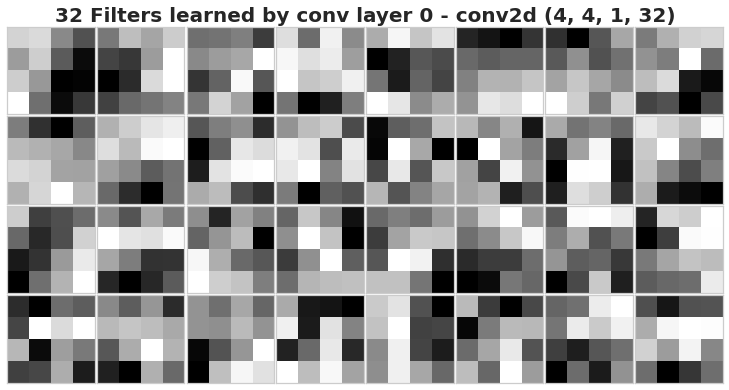

In [76]:
visualise_filters(model_cnn_01, 0, 4)

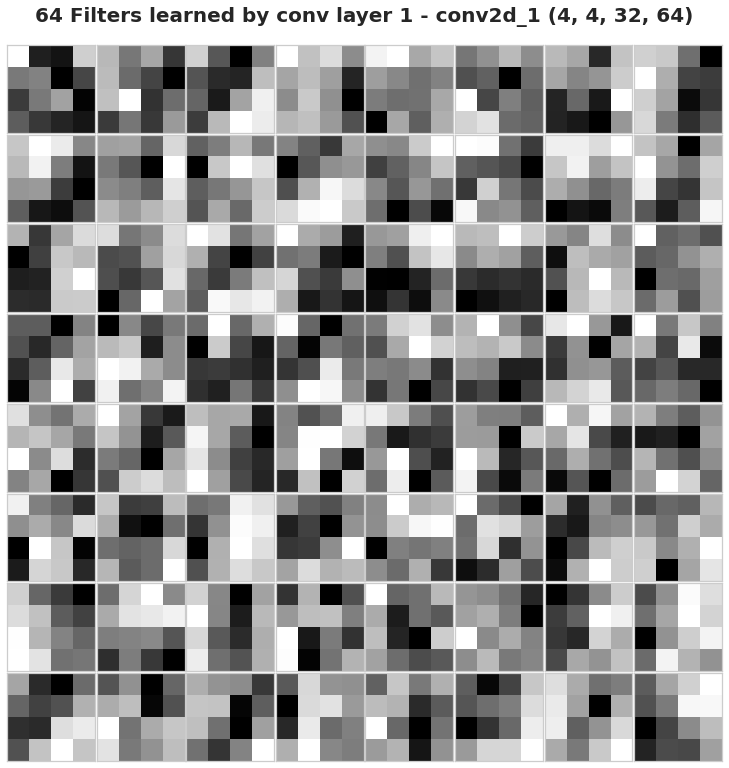

In [77]:
visualise_filters(model_cnn_01, 1, 8, figsize=(10,10))

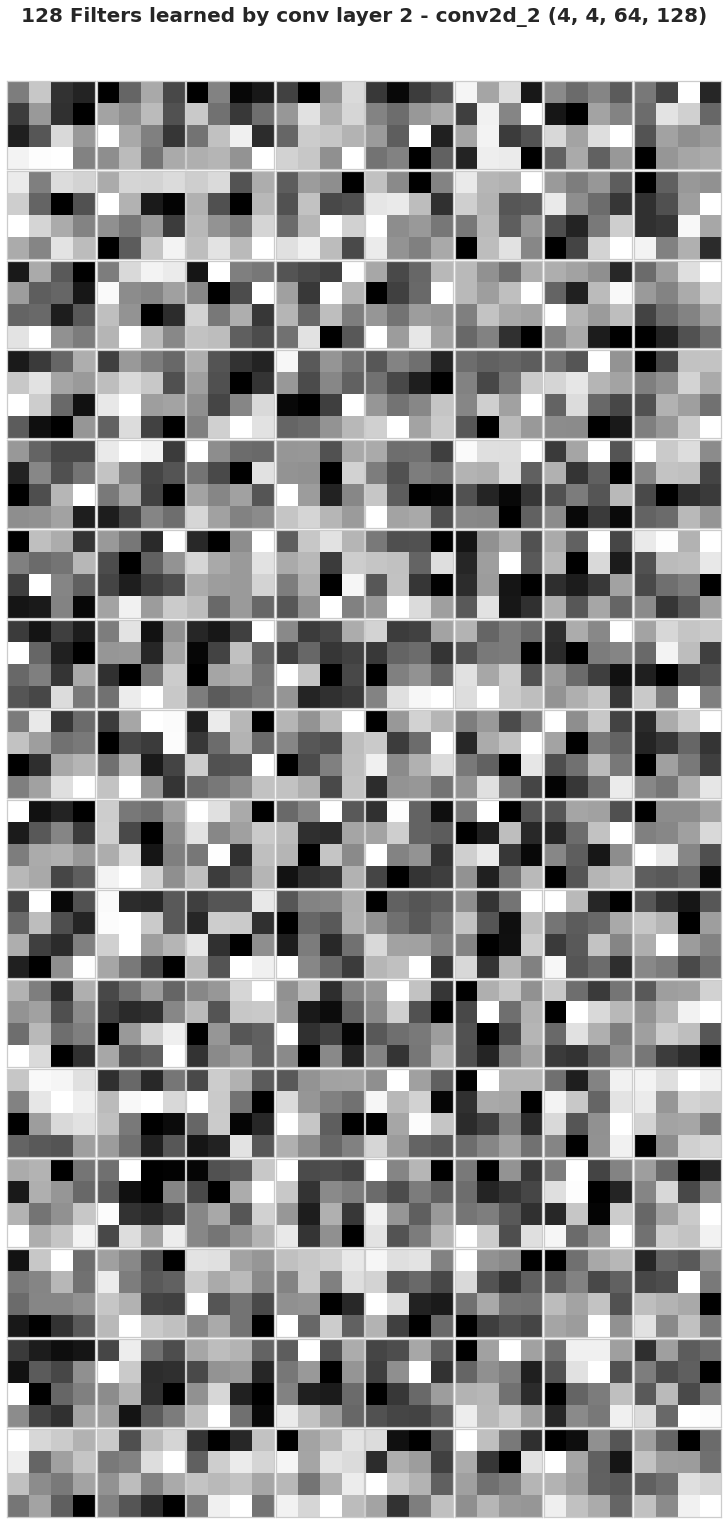

In [78]:
visualise_filters(model_cnn_01, 2, 16, figsize=(10,20))

Visualising the learned filters of a CNN provides insight into CNN search patterns in the input image. The first convolutional layer filters are applied directly to the input image. Here we see that most filters contain lighter and darker areas, suggesting the filter is looking to identify the edges of the number in the image. There are also clear straight lines or curves in certain filters, which may be useful in telling certain numbers apart even in this early stage.
The second and third layer filter patterns are less clear as these are applied on already convolved images. We observe subtler gradients here, suggesting these filters discern broader trends.

## 5.2 Activation Plots

In [79]:
from keras.models import Model
outputs = [model_cnn_01.layers[i].output for i in conv_layers]
model_short = Model(inputs=model_cnn_01.inputs, outputs=outputs)
print(model_short.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 25, 25, 32)        544       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         131200    
                                                                 
Total params: 164,576
Trainable params: 164,576
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
# "2" image = x_test[1]

test_img = np.expand_dims(x_test[1], axis=0)

feature_output = model_short.predict(test_img)
feature_output[1].shape

(1, 11, 11, 64)

In [81]:
def visualise_maps(feature_output, conv_layer, nrows, figsize):
    n_maps = feature_output[conv_layer].shape[3]
    
    fig, axes = plt.subplots(nrows=nrows, ncols=8, figsize=figsize)

    for i in range(n_maps):
        ax = axes[int(i / 8), i % 8]
        ax.imshow(feature_output[conv_layer][0, :, :, i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.set_title('Map ' + str(i + 1))

    fig.tight_layout(pad=0.1)

    fig.suptitle(f'{n_maps} Feature Maps learned by the {conv_layer + 1} conv layer', 
                fontsize=20,
                fontweight="bold",
                y=1.05
                )

    plt.show()

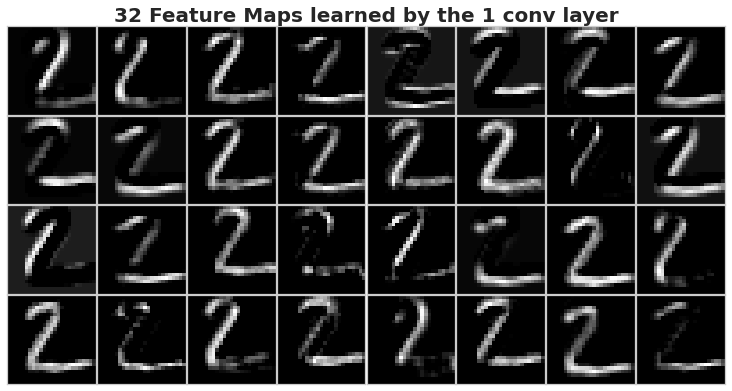

In [82]:
visualise_maps(feature_output, 0, 4, (10, 5))

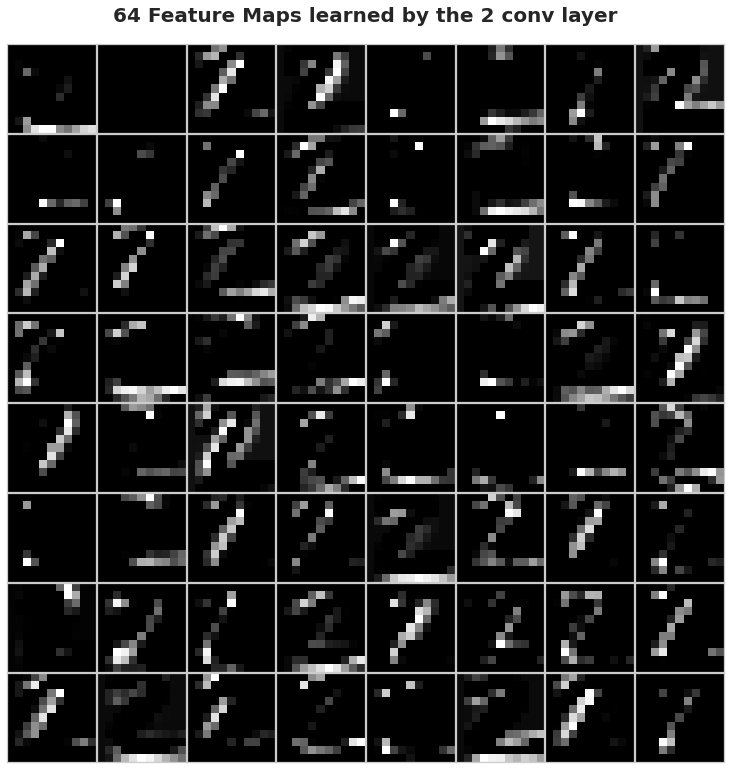

In [83]:
visualise_maps(feature_output, 1, 8, (10, 10))

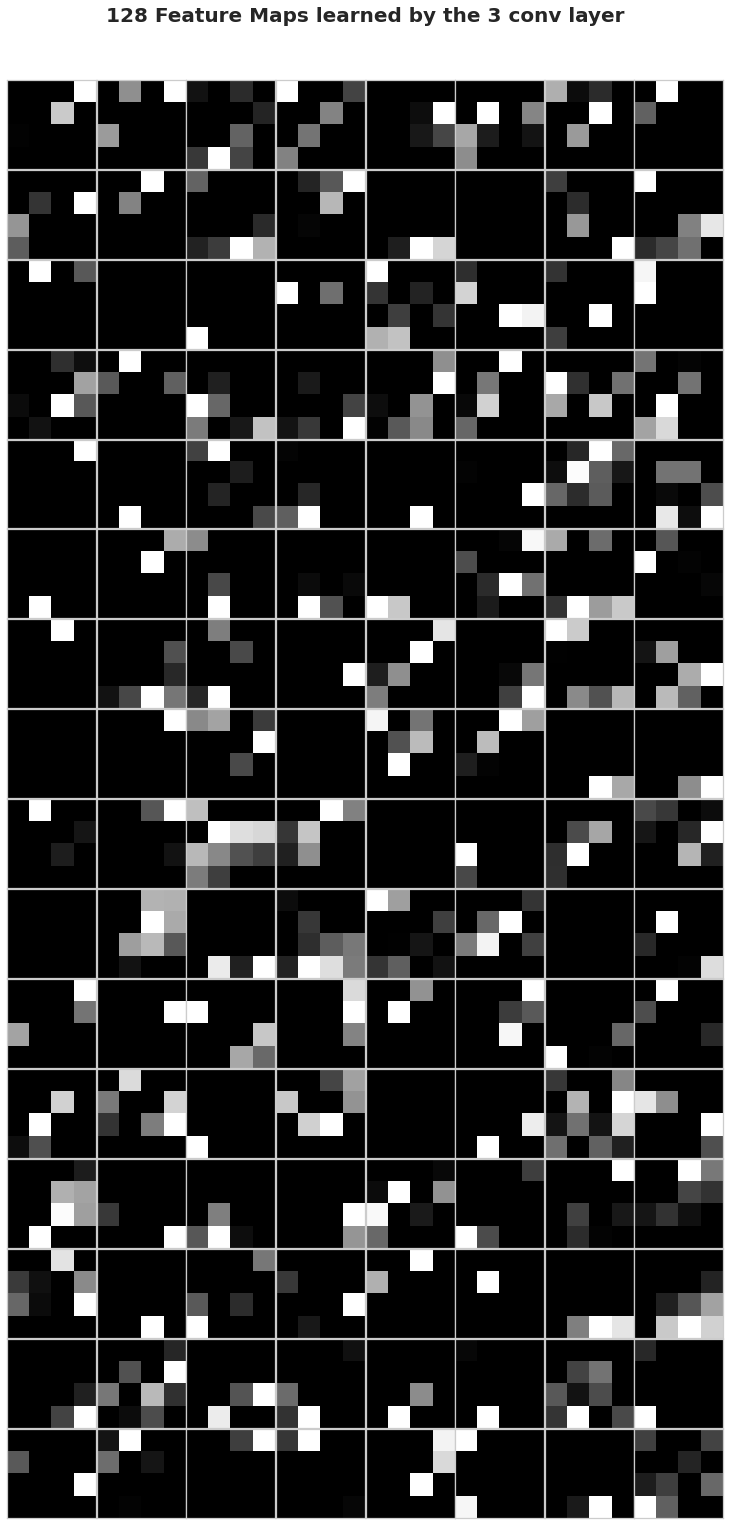

In [84]:
visualise_maps(feature_output, 2, 16, (10, 20))

The above images show each layer’s output when each filter is applied to the input to the layer. The first layer’s filters pick up different aspects of the input image, particularly its edges, confirming the observations made when reviewing filters. However, many filters in the second layer produce a diagonal line, indicating this is a defining feature of “2”. As with the filters, the third layer is harder to parse, although the diagonal line from the second layer is present in some of the activations.

In [85]:
# "9" image = x_test[7]

test_img = np.expand_dims(x_test[7], axis=0)

feature_output = model_short.predict(test_img)
feature_output[1].shape

(1, 11, 11, 64)

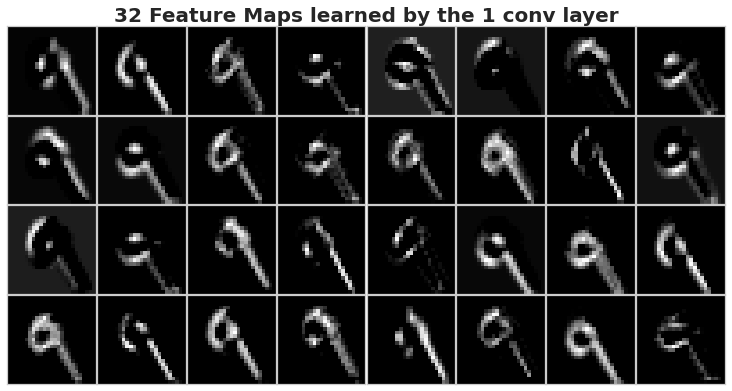

In [86]:
visualise_maps(feature_output, 0, 4, (10, 5))

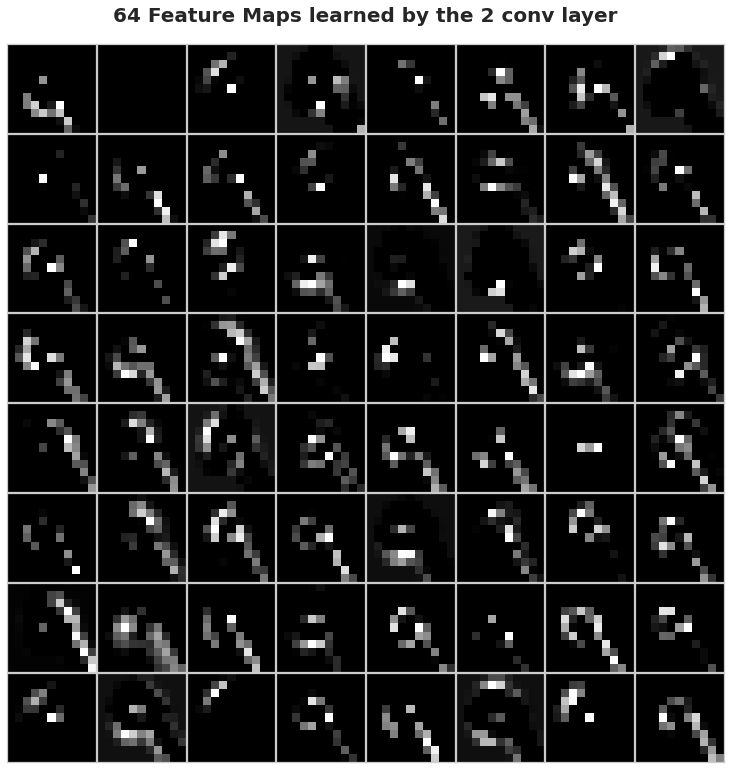

In [87]:
visualise_maps(feature_output, 1, 8, (10, 10))

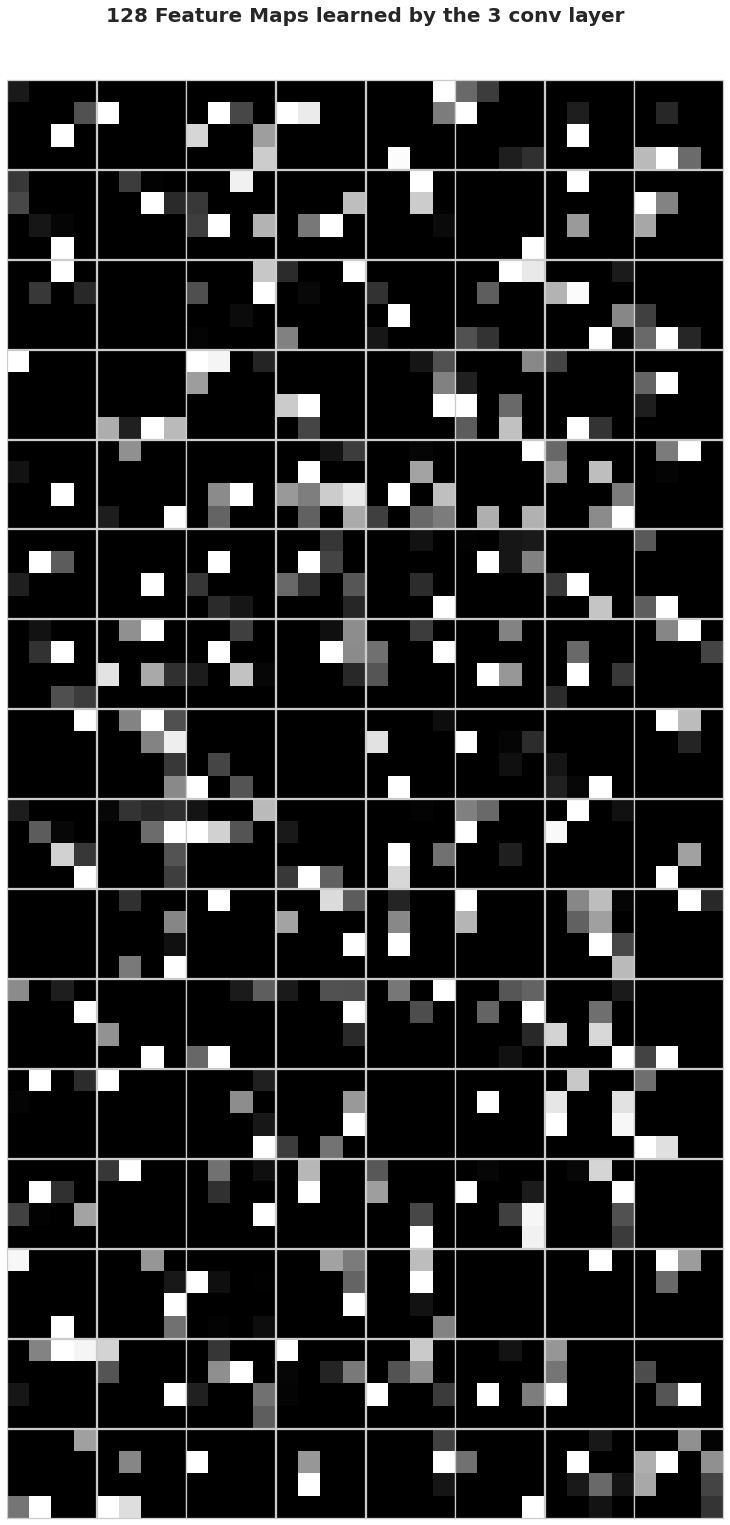

In [88]:
visualise_maps(feature_output, 2, 16, (10, 20))

As with “2”, the edges present the first activation layer of “9” highlight the number’s key characteristics. While less distinct, the second layer filters pick up on the “tail” and “loop” of the 9, suggesting these are key differentiators between classes. Similar to “2”, third layer activations pick up some features of the 9 (e.g. the tail), although this is blurred.

## 5.3 Deep Dream Plots

Deep Dream images provide another way of visualising the CNN process. Instead of classifying input images based on output layer activation, the activation of a particular output class is maximised using gradient ascent and the input image fitted accordingly. Theoretically, we can observe the patterns the network looks for in a given class. Three images were selected for “2” and “9”. The first is a randomly initialised image. The second and third were chosen from the test data. Gradient ascent is run for 500 iterations, and the results are visualised. 

The code in this section is a modified version of the Tensorflow deepdream tutorial: https://www.tensorflow.org/tutorials/generative/deepdream.

In [89]:
model_cnn_01.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        544       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         131200    
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_23 (Dense)            (None, 10)                20490     
                                                                 
Total params: 185,066
Trainable params: 185,066
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Setting up the base model and selecting the output layer

base_model = model_cnn_01
layer_name = 'dense_23'
layer = base_model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=base_model.inputs, outputs=layer.output)

In [92]:
def calc_loss(img, model, neuron):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = [model(img_batch)[0][neuron]]
  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

@tf.function
def gradient_ascent_step(img, model, neuron, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calc_loss(img, model, neuron)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

def visualize_filter(img, model, neuron, learning_rate=1, iterations=500):
    # We run gradient ascent
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, model, neuron, learning_rate)
    img = img.numpy().reshape((28, 28))
    return img

def random_image():
  img = tf.random.uniform((28, 28, 1))
  return img

In [93]:
sample_image = random_image()
sample_im_display = sample_image.numpy().reshape((28, 28))

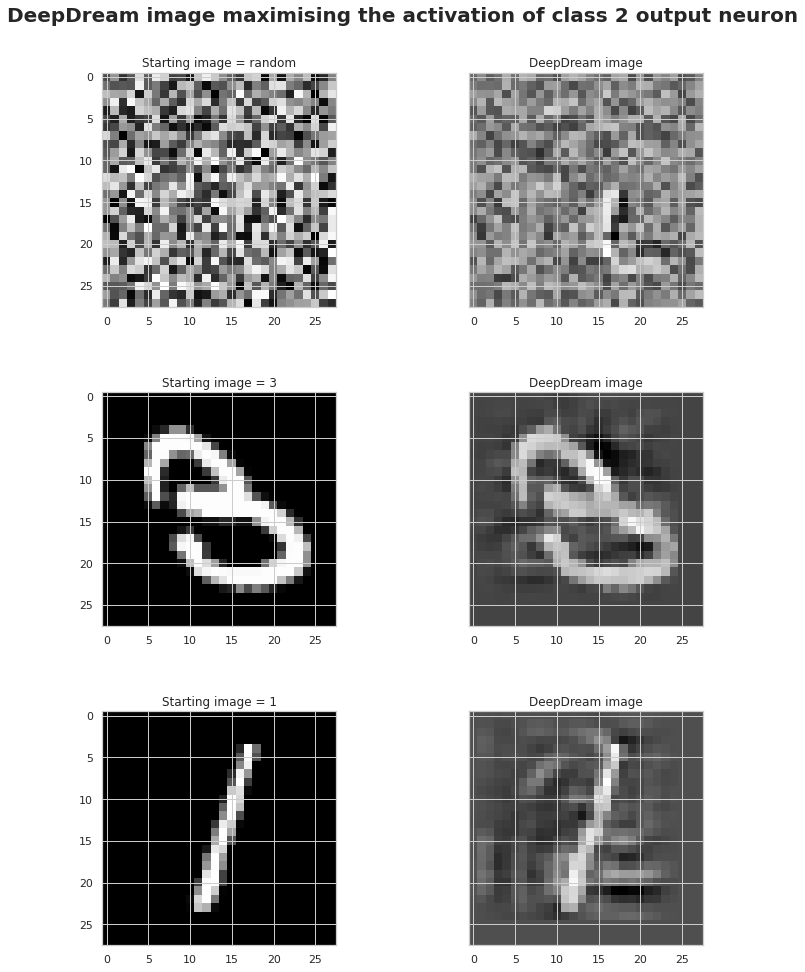

In [94]:
img1 = visualize_filter(sample_image, feature_extractor, 2)
img2 = visualize_filter(x_test[18], feature_extractor, 2)
img3 = visualize_filter(x_test[2], feature_extractor, 2)

fig, ax = plt.subplots(3, 2, figsize=(12, 14), sharey='all')

ax[0, 0].imshow(sample_im_display, cmap='gray')
ax[0, 1].imshow(img1, cmap='gray')
ax[1, 0].imshow(x_test[18].reshape(28, 28), cmap='gray')
ax[1, 1].imshow(img2, cmap='gray')
ax[2, 0].imshow(x_test[2].reshape(28, 28), cmap='gray')
ax[2, 1].imshow(img3, cmap='gray')

ax[0, 0].set_title('Starting image = random', fontdict={'fontsize': 12, })
ax[0, 1].set_title('DeepDream image', fontdict={'fontsize': 12, })
ax[1, 0].set_title('Starting image = 3', fontdict={'fontsize': 12, })
ax[1, 1].set_title('DeepDream image', fontdict={'fontsize': 12, })
ax[2, 0].set_title('Starting image = 1', fontdict={'fontsize': 12, })
ax[2, 1].set_title('DeepDream image', fontdict={'fontsize': 12, })

fig.suptitle('DeepDream image maximising the activation of class 2 output neuron', y=1,
             fontsize=20, fontweight='bold', ha='center')
fig.tight_layout(pad=5)
plt.show()

The random starting image has a faint output of “2”, suggesting that the network is looking for recognisable features of the “2” class. From the “3” starting image, the network seems less certain of how to change the image to make it more 2-like, possibly due to the classes sharing common features. The “1” starting image is clearer, with the diagonal line being preserved and more “2-like” features added.

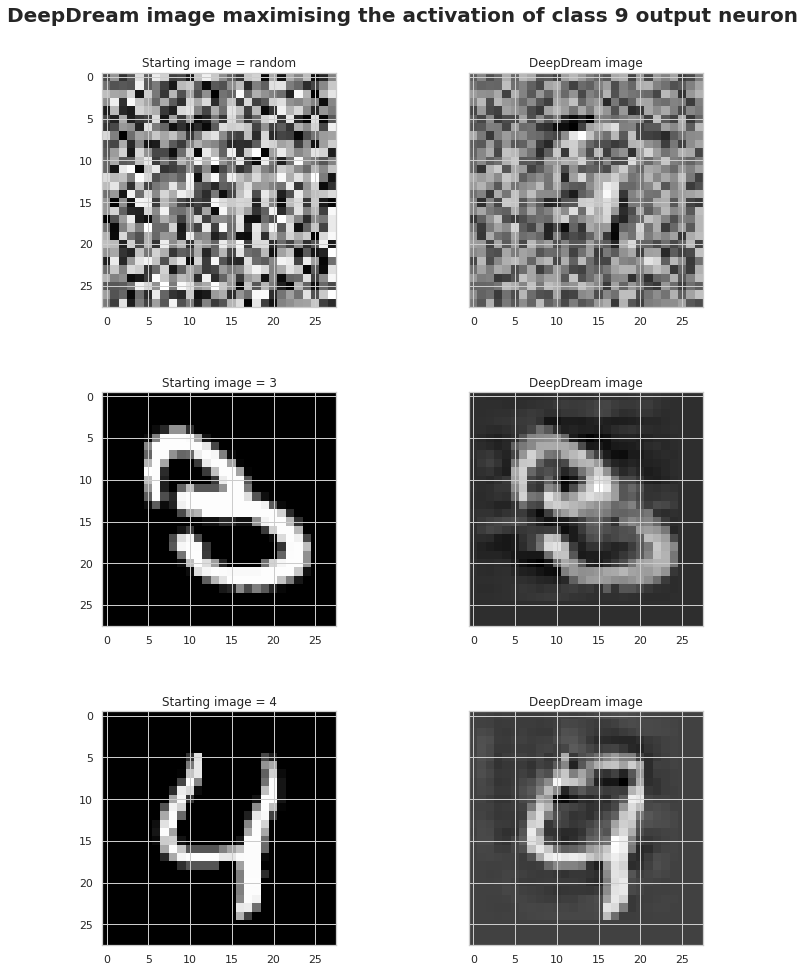

In [95]:
img1 = visualize_filter(sample_image, feature_extractor, 9)
img2 = visualize_filter(x_test[18], feature_extractor, 9)
img3 = visualize_filter(x_test[4], feature_extractor, 9)

fig, ax = plt.subplots(3, 2, figsize=(12, 14), sharey='all')

ax[0, 0].imshow(sample_im_display, cmap='gray')
ax[0, 1].imshow(img1, cmap='gray')
ax[1, 0].imshow(x_test[18].reshape(28, 28), cmap='gray')
ax[1, 1].imshow(img2, cmap='gray')
ax[2, 0].imshow(x_test[4].reshape(28, 28), cmap='gray')
ax[2, 1].imshow(img3, cmap='gray')

ax[0, 0].set_title('Starting image = random', fontdict={'fontsize': 12, })
ax[0, 1].set_title('DeepDream image', fontdict={'fontsize': 12, })
ax[1, 0].set_title('Starting image = 3', fontdict={'fontsize': 12, })
ax[1, 1].set_title('DeepDream image', fontdict={'fontsize': 12, })
ax[2, 0].set_title('Starting image = 4', fontdict={'fontsize': 12, })
ax[2, 1].set_title('DeepDream image', fontdict={'fontsize': 12, })

fig.suptitle('DeepDream image maximising the activation of class 9 output neuron', y=1,
             fontsize=20, fontweight='bold', ha='center')
fig.tight_layout(pad=5)
plt.show()

A random initiation results in the outline of a nine. The output from “3”, while ambiguous, creates the nine’s “loop” from the top part of the 3. The output from “4” includes a line across the top, making the nine loop. This shows the CNN’s ability to create recognisable structure even from an image quite different from the most class “9” images, suggesting the network can learn important features and is less vulnerable to image manipulation.

# Section 6: Multi-Task Learning

This section looks at the Fashion MNIST classification data. Two separate CNN architectures are built, one for item classification (identifying a boot, shirt, dress etc) and one for item group classification (identifying footware, unisex clothing etc). We then investigate whether a multi-task learning architecture trained on both tasks simultaneously can perform better than either separate network. This architecture uses a parameter λ to weigh prioritisation of the different tasks.

In [96]:
import keras.datasets.fashion_mnist as fashion_mnist
from tensorflow.keras.utils import to_categorical

def load_data():
  (train_X, train_y1), (test_X, test_y1) = fashion_mnist.load_data()
  n_class_1 = 10
  train_y2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in train_y1)
  test_y2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in test_y1)
  n_class_2 = 3

  train_X = np.expand_dims(train_X, axis=3)
  test_X = np.expand_dims(test_X, axis=3)
  train_y1 = to_categorical(train_y1, n_class_1)
  test_y1 = to_categorical(test_y1, n_class_1)
  train_y2 = to_categorical(train_y2, n_class_2)
  test_y2 = to_categorical(test_y2, n_class_2)

  return train_X, train_y1, train_y2, test_X, test_y1, test_y2

x_train, y1_train, y2_train, x_test, y1_test, y2_test = load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [97]:
# Scale images to the [0, 1] range as with handwritten digit data

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

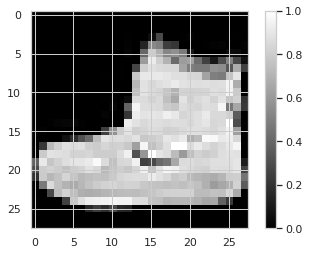

In [98]:
fig, ax = plt.subplots()
ax.imshow(np.reshape(x_train[0], (28, 28)), cmap='gray')
fig.colorbar(ax.images[0], ax=ax)
plt.show()

In [99]:
print("x_train shape:", x_train.shape)
print("training samples:", x_train.shape[0])
print("testing samples:", x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
training samples: 60000
testing samples: 10000


## 6.1 Separate classification

In [100]:
input_shape = (28, 28, 1)

In [101]:
# epochs, batch size, learning rate same as in task 4

# Item Classification

model_name = "CNN_Item_Classification"
n_classes = 10

epochs = 10
batch_size = 120
learning_rate = 0.001
conv_layers = [32, 64, 128]
dense_layers = [3136, 1024, 100, n_classes]
kernel_size = [(3, 3), (3, 3), (3, 3)]
strides = [(1, 1), (1, 1), (1, 1)]
pool_size = [(2, 2), (2, 2)]
pool_strides = [(2, 2), (2, 2)]

hidden_activation = 'relu'
output_layer_activation = 'softmax'
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

# Create the model
model_cnn_itemclass = keras.Sequential([
    keras.Input(shape=input_shape),
    Conv2D(conv_layers[0], kernel_size=kernel_size[0], strides=strides[0], activation=hidden_activation),
    MaxPooling2D(pool_size=pool_size[0], strides=pool_strides[0]),
    Conv2D(conv_layers[1], kernel_size=kernel_size[1], strides=strides[1], activation=hidden_activation),
    MaxPooling2D(pool_size=pool_size[1], strides=pool_strides[1]),
    Conv2D(conv_layers[2], kernel_size=kernel_size[2], strides=strides[2], activation=hidden_activation),
    Flatten(),
    Dense(dense_layers[0], activation=hidden_activation),
    Dense(dense_layers[1], activation=hidden_activation),
    Dense(dense_layers[2], activation=hidden_activation),
    Dense(dense_layers[3], activation=output_layer_activation),
])

model_cnn_itemclass.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 flatten_10 (Flatten)        (None, 1152)            

In [102]:
model_cnn_itemclass.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

model_cnn_itemclass.fit(
    x_train, y1_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y1_test),
)


Epoch 1/10
500/500 [==============================] - 4s 7ms/step - loss: 0.5195 - accuracy: 0.8052 - val_loss: 0.3564 - val_accuracy: 0.8700
Epoch 2/10
500/500 [==============================] - 3s 6ms/step - loss: 0.3100 - accuracy: 0.8859 - val_loss: 0.2962 - val_accuracy: 0.8940
Epoch 3/10
500/500 [==============================] - 3s 6ms/step - loss: 0.2590 - accuracy: 0.9037 - val_loss: 0.2870 - val_accuracy: 0.8988
Epoch 4/10
500/500 [==============================] - 3s 6ms/step - loss: 0.2318 - accuracy: 0.9141 - val_loss: 0.2771 - val_accuracy: 0.9034
Epoch 5/10
500/500 [==============================] - 3s 6ms/step - loss: 0.2047 - accuracy: 0.9238 - val_loss: 0.2623 - val_accuracy: 0.9086
Epoch 6/10
500/500 [==============================] - 3s 6ms/step - loss: 0.1836 - accuracy: 0.9318 - val_loss: 0.2646 - val_accuracy: 0.9062
Epoch 7/10
500/500 [==============================] - 4s 9ms/step - loss: 0.1620 - accuracy: 0.9408 - val_loss: 0.2642 - val_accuracy: 0.9096
Epoch 

In [103]:
summary_list_mtl = []
train_acc, test_acc = model_cnn_itemclass.evaluate(x_train, y1_train), model_cnn_itemclass.evaluate(x_test, y1_test)
summary_list_mtl.append((model_name, model_cnn_itemclass.count_params(), train_acc[1], test_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.2906 - accuracy: 0.9133


In [104]:
# Item Group Classification

model_name = "CNN_Item_Group_Classification"
n_classes = 3

epochs = 10
batch_size = 120
learning_rate = 0.001
conv_layers = [32, 64, 128]
dense_layers = [3136, 1024, 100, n_classes]
kernel_size = [(3, 3), (3, 3), (3, 3)]
strides = [(1, 1), (1, 1), (1, 1)]
pool_size = [(2, 2), (2, 2)]
pool_strides = [(2, 2), (2, 2)]

hidden_activation = 'relu'
output_layer_activation = 'softmax'
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

# Create the model
model_cnn_itemgroupclass = keras.Sequential([
    keras.Input(shape=input_shape),
    Conv2D(conv_layers[0], kernel_size=kernel_size[0], strides=strides[0], activation=hidden_activation),
    MaxPooling2D(pool_size=pool_size[0], strides=pool_strides[0]),
    Conv2D(conv_layers[1], kernel_size=kernel_size[1], strides=strides[1], activation=hidden_activation),
    MaxPooling2D(pool_size=pool_size[1], strides=pool_strides[1]),
    Conv2D(conv_layers[2], kernel_size=kernel_size[2], strides=strides[2], activation=hidden_activation),
    Flatten(),
    Dense(dense_layers[0], activation=hidden_activation),
    Dense(dense_layers[1], activation=hidden_activation),
    Dense(dense_layers[2], activation=hidden_activation),
    Dense(dense_layers[3], activation=output_layer_activation),
])


model_cnn_itemgroupclass.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 flatten_11 (Flatten)        (None, 1152)            

In [105]:
model_cnn_itemgroupclass.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

model_cnn_itemgroupclass.fit(
    x_train, y2_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y2_test),
)

Epoch 1/10
500/500 [==============================] - 4s 7ms/step - loss: 0.2660 - accuracy: 0.8784 - val_loss: 0.2066 - val_accuracy: 0.9100
Epoch 2/10
500/500 [==============================] - 3s 6ms/step - loss: 0.1795 - accuracy: 0.9207 - val_loss: 0.1827 - val_accuracy: 0.9228
Epoch 3/10
500/500 [==============================] - 3s 6ms/step - loss: 0.1562 - accuracy: 0.9312 - val_loss: 0.1644 - val_accuracy: 0.9257
Epoch 4/10
500/500 [==============================] - 3s 6ms/step - loss: 0.1415 - accuracy: 0.9387 - val_loss: 0.1605 - val_accuracy: 0.9325
Epoch 5/10
500/500 [==============================] - 3s 6ms/step - loss: 0.1300 - accuracy: 0.9446 - val_loss: 0.1643 - val_accuracy: 0.9318
Epoch 6/10
500/500 [==============================] - 3s 6ms/step - loss: 0.1210 - accuracy: 0.9486 - val_loss: 0.1634 - val_accuracy: 0.9265
Epoch 7/10
500/500 [==============================] - 3s 6ms/step - loss: 0.1083 - accuracy: 0.9543 - val_loss: 0.1767 - val_accuracy: 0.9317
Epoch 

In [106]:
train_acc, test_acc = model_cnn_itemgroupclass.evaluate(x_train, y2_train), model_cnn_itemgroupclass.evaluate(x_test, y2_test)
summary_list_mtl.append((model_name, model_cnn_itemgroupclass.count_params(), train_acc[1], test_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.1661 - accuracy: 0.9380


In [107]:
df = pd.DataFrame(summary_list_mtl, columns=['Model', '# Parameters', 'Training data accuracy', 'Test data accuracy'])
df

,Model,# Parameters,Training data accuracy,Test data accuracy
0,CNN_Item_Classification,7024278,0.967583,0.9133
1,CNN_Item_Group_Classification,7023571,0.969700,0.9380


## 6.2 - Building an MTL Network

In [108]:
model_name = "CNN_MTL_Classification"
y1_classes = 10
y2_classes = 3

epochs = 10
batch_size = 120
learning_rate = 0.001
conv_layers = [32, 64, 128]
shared_dense_layers = [3136]
task1_dense_layers = [1024, 100, y1_classes]
task2_dense_layers = [1024, 100, y2_classes]
kernel_size = [(3, 3), (3, 3), (3, 3)]
strides = [(1, 1), (1, 1), (1, 1)]
pool_size = [(2, 2), (2, 2)]
pool_strides = [(2, 2), (2, 2)]

hidden_activation = 'relu'
output_layer_activation = 'softmax'
optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']


input = keras.Input(shape=input_shape)
shared_conv1 = Conv2D(conv_layers[0], kernel_size=kernel_size[0], strides=strides[0], activation=hidden_activation)
shared_pool1 = MaxPooling2D(pool_size=pool_size[0], strides=pool_strides[0])
shared_conv2 = Conv2D(conv_layers[1], kernel_size=kernel_size[1], strides=strides[1], activation=hidden_activation)
shared_pool2 = MaxPooling2D(pool_size=pool_size[1], strides=pool_strides[1])
shared_conv3 = Conv2D(conv_layers[2], kernel_size=kernel_size[2], strides=strides[2], activation=hidden_activation)
shared_dense = Dense(shared_dense_layers[0], activation=hidden_activation)

task1_dense1 = Dense(task1_dense_layers[0], activation=hidden_activation)
task1_dense2 = Dense(task1_dense_layers[1], activation=hidden_activation)
task1_dense3 = Dense(task1_dense_layers[2], activation=output_layer_activation)

task2_dense1 = Dense(task2_dense_layers[0], activation=hidden_activation)
task2_dense2 = Dense(task2_dense_layers[1], activation=hidden_activation)
task2_dense3 = Dense(task2_dense_layers[2], activation=output_layer_activation)

# Create the model
    
model = shared_conv1(input)
model = shared_pool1(model)
model = shared_conv2(model)
model = shared_pool2(model)
model = shared_conv3(model)
model = Flatten()(model)
model = shared_dense(model)

task1 = task1_dense1(model)
task1 = task1_dense2(task1)
task1 = task1_dense3(task1)

task2 = task2_dense1(model)
task2 = task2_dense2(task2)
task2 = task2_dense3(task2)

model_cnn_mtl = keras.Model(inputs=[input], outputs=[task1, task2])

model_cnn_mtl.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_23 (Conv2D)             (None, 26, 26, 32)   320         ['input_8[0][0]']                
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 13, 13, 32)  0           ['conv2d_23[0][0]']              
                                                                                                  
 conv2d_24 (Conv2D)             (None, 11, 11, 64)   18496       ['max_pooling2d_6[0][0]']        
                                                                                            

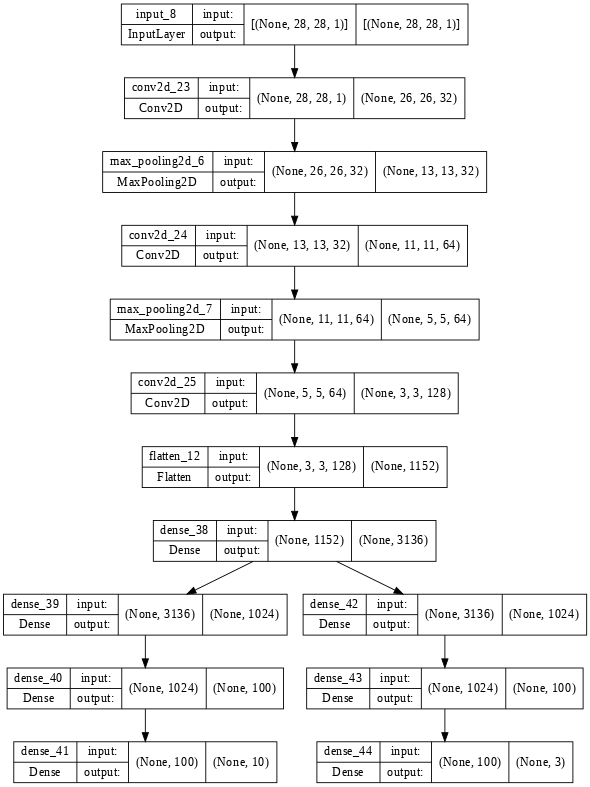

In [109]:
tf.keras.utils.plot_model(model_cnn_mtl, show_shapes=True, expand_nested=True, dpi=64)

In [110]:
# Define the loss function
t1_weighting = 0.5
t2_weighting = 1 - t1_weighting
losses = {model_cnn_mtl.layers[-2]._name: "categorical_crossentropy", model_cnn_mtl.layers[-1]._name: "categorical_crossentropy"}
loss_weights = {model_cnn_mtl.layers[-2]._name: t1_weighting, model_cnn_mtl.layers[-1]._name: t2_weighting}

In [111]:
model_cnn_mtl.compile(
    loss=losses,
    loss_weights=loss_weights,
    optimizer=optimizer,
    metrics=metrics
)

model_cnn_mtl.fit(
    x_train, 
    {model_cnn_mtl.layers[-2]._name: y1_train, model_cnn_mtl.layers[-1]._name: y2_train},
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, {model_cnn_mtl.layers[-2]._name: y1_test, model_cnn_mtl.layers[-1]._name: y2_test}),
)

Epoch 1/10
500/500 [==============================] - 5s 9ms/step - loss: 0.3915 - dense_41_loss: 0.5228 - dense_44_loss: 0.2602 - dense_41_accuracy: 0.8020 - dense_44_accuracy: 0.8769 - val_loss: 0.2965 - val_dense_41_loss: 0.3792 - val_dense_44_loss: 0.2138 - val_dense_41_accuracy: 0.8597 - val_dense_44_accuracy: 0.8998
Epoch 2/10
500/500 [==============================] - 4s 8ms/step - loss: 0.2397 - dense_41_loss: 0.3130 - dense_44_loss: 0.1665 - dense_41_accuracy: 0.8850 - dense_44_accuracy: 0.9275 - val_loss: 0.2333 - val_dense_41_loss: 0.3068 - val_dense_44_loss: 0.1597 - val_dense_41_accuracy: 0.8844 - val_dense_44_accuracy: 0.9306
Epoch 3/10
500/500 [==============================] - 4s 8ms/step - loss: 0.2002 - dense_41_loss: 0.2601 - dense_44_loss: 0.1404 - dense_41_accuracy: 0.9047 - dense_44_accuracy: 0.9390 - val_loss: 0.2185 - val_dense_41_loss: 0.2826 - val_dense_44_loss: 0.1545 - val_dense_41_accuracy: 0.8940 - val_dense_44_accuracy: 0.9305
Epoch 4/10
500/500 [========

In [112]:
test_acc = model_cnn_mtl.evaluate(x_test, {model_cnn_mtl.layers[-2]._name: y1_test, model_cnn_mtl.layers[-1]._name: y2_test})
item_test_acc = test_acc[3]
group_test_acc = test_acc[4]

313/313 [==============================] - 1s 4ms/step - loss: 0.2271 - dense_41_loss: 0.2943 - dense_44_loss: 0.1599 - dense_41_accuracy: 0.9136 - dense_44_accuracy: 0.9455


In [113]:
def create_mtl_model(t1_weighting):

    y1_classes = 10
    y2_classes = 3

    epochs = 10
    batch_size = 120
    learning_rate = 0.001
    conv_layers = [32, 64, 128]
    shared_dense_layers = [3136]
    task1_dense_layers = [1024, 100, y1_classes]
    task2_dense_layers = [1024, 100, y2_classes]
    kernel_size = [(3, 3), (3, 3), (3, 3)]
    strides = [(1, 1), (1, 1), (1, 1)]
    pool_size = [(2, 2), (2, 2)]
    pool_strides = [(2, 2), (2, 2)]

    hidden_activation = 'relu'
    output_layer_activation = 'softmax'
    optimizer = 'adam'
    loss = 'categorical_crossentropy'
    metrics = ['accuracy']


    input = keras.Input(shape=input_shape)
    shared_conv1 = Conv2D(conv_layers[0], kernel_size=kernel_size[0], strides=strides[0], activation=hidden_activation)
    shared_pool1 = MaxPooling2D(pool_size=pool_size[0], strides=pool_strides[0])
    shared_conv2 = Conv2D(conv_layers[1], kernel_size=kernel_size[1], strides=strides[1], activation=hidden_activation)
    shared_pool2 = MaxPooling2D(pool_size=pool_size[1], strides=pool_strides[1])
    shared_conv3 = Conv2D(conv_layers[2], kernel_size=kernel_size[2], strides=strides[2], activation=hidden_activation)
    shared_dense = Dense(shared_dense_layers[0], activation=hidden_activation)

    task1_dense1 = Dense(task1_dense_layers[0], activation=hidden_activation)
    task1_dense2 = Dense(task1_dense_layers[1], activation=hidden_activation)
    task1_dense3 = Dense(task1_dense_layers[2], activation=output_layer_activation)

    task2_dense1 = Dense(task2_dense_layers[0], activation=hidden_activation)
    task2_dense2 = Dense(task2_dense_layers[1], activation=hidden_activation)
    task2_dense3 = Dense(task2_dense_layers[2], activation=output_layer_activation)

    # Create the model
        
    model = shared_conv1(input)
    model = shared_pool1(model)
    model = shared_conv2(model)
    model = shared_pool2(model)
    model = shared_conv3(model)
    model = Flatten()(model)
    model = shared_dense(model)

    task1 = task1_dense1(model)
    task1 = task1_dense2(task1)
    task1 = task1_dense3(task1)

    task2 = task2_dense1(model)
    task2 = task2_dense2(task2)
    task2 = task2_dense3(task2)

    model_cnn_mtl = keras.Model(inputs=[input], outputs=[task1, task2])

    # Define the loss function
    t2_weighting = 1 - t1_weighting
    losses = {model_cnn_mtl.layers[-2]._name: "categorical_crossentropy", model_cnn_mtl.layers[-1]._name: "categorical_crossentropy"}
    loss_weights = {model_cnn_mtl.layers[-2]._name: t1_weighting, model_cnn_mtl.layers[-1]._name: t2_weighting}

    model_cnn_mtl.compile(
    loss=losses,
    loss_weights=loss_weights,
    optimizer=optimizer,
    metrics=metrics)

    model_cnn_mtl.fit(
    x_train, 
    {model_cnn_mtl.layers[-2]._name: y1_train, model_cnn_mtl.layers[-1]._name: y2_train},
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    validation_data=(x_test, {model_cnn_mtl.layers[-2]._name: y1_test, model_cnn_mtl.layers[-1]._name: y2_test}))

    test_acc = model_cnn_mtl.evaluate(x_test, {model_cnn_mtl.layers[-2]._name: y1_test, model_cnn_mtl.layers[-1]._name: y2_test})
    item_test_acc = test_acc[3]
    group_test_acc = test_acc[4]

    return item_test_acc, group_test_acc

In [114]:
weighting_list = [0, 0.25, 0.5, 0.75, 1]
weighting_eval_list = []
for weighting in weighting_list:
  item_test_acc, group_test_acc = create_mtl_model(weighting)
  weighting_eval_list.append((weighting, item_test_acc, group_test_acc))

313/313 [==============================] - 1s 4ms/step - loss: 0.3134 - dense_76_loss: 0.3134 - dense_79_loss: 1.0937 - dense_76_accuracy: 0.9056 - dense_79_accuracy: 0.4378


In [115]:
df = pd.DataFrame(weighting_eval_list, columns=['Lambda', 'Item test accuracy', 'Group test accuracy'])
df

,Lambda,Item test accuracy,Group test accuracy
0,0.00,0.1276,0.9357
1,0.25,0.9103,0.9416
2,0.50,0.9109,0.9440
3,0.75,0.9086,0.9407
4,1.00,0.9056,0.4378


Looking at the extreme cases of λ=1 and λ=0. When λ=1, the network functions in the same way as the 10-item classifier. In this case, the 10-item classification accuracy is 91.02%, similar to the 90.15% observed using a single task CNN. The 3-item group classification accuracy is 32.27%, approximately the percentage expected if the network randomly classifies the images. This makes sense given that the network was not trained using the 3-item group loss function. When λ=0, a similar pattern is seen but in reverse. The 10-item classification accuracy of 16.62% is somewhat better than chance. We would expect 10% if the network were classifying randomly.

When 0.25 ≤ λ ≤0.75, accuracies on both classification problems increase significantly. When λ=0.25 (the highest overall score), 10-item classification is 0.9% better than with the single task CNN, and 3-item group classification improves by 0.68%, suggesting small synergies that can be leveraged from one task to another.
When using an MTL approach, it is important to consider if objective overlap exists between tasks, as these tasks are most likely to benefit from learning shared features. Additionally, given that MTL uses a shared architecture for a large part of the network, one must consider whether both tasks benefit from this architecture.
As noted by Zhang and Yang (2018), “sharing knowledge among tasks is very useful when all the tasks are very similar, but when this assumption is violated, the performance will significantly deteriorate”. Future research could focus on multi-task learning on more diverse tasks, which could be a key building block for more general AI.
